In [ ]:
# For colab only
# %pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
# %pip install transformers accelerate datasets
# %pip install tqdm
# %pip install numpy
# %pip install scikit-learn
# %pip install opencv-python
# %pip install tensorboardX
# %pip install pandas

In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision.transforms import GaussianBlur
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, zoom, mean as ndimage_mean
from skimage.transform import resize
import cv2


c:\Users\Varun\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Varun\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Functions for degradation

In [3]:
# Functions for pixellation

def upsample_nearest(image, new_width, new_height):

    old_height, old_width = image.shape[-2:]
    scale_x = new_width / old_width
    scale_y = new_height / old_height

    # Create the coordinate grid for the new image
    x_indices = (np.arange(new_width) / scale_x).astype(int)
    y_indices = (np.arange(new_height) / scale_y).astype(int)

    # Use advanced indexing to map the input pixels to the new grid
    upsampled_image = image[:,y_indices[:, None], x_indices]
    return upsampled_image

def downsample_to_fixed_size(image, target_size):

    num_channels, input_height, input_width = image.shape
    target_rows, target_cols = target_size

    # Calculate the scaling factors
    row_scale = input_height / target_rows
    col_scale = input_width / target_cols

    # Create an empty array for the downsampled image
    downsampled_image = np.zeros((num_channels,target_rows, target_cols), dtype=np.float32)

    for row in range(target_rows):
        for col in range(target_cols):
            # Determine the boundaries of the region in the original image
            row_start = int(row * row_scale)
            row_end = int((row + 1) * row_scale)
            col_start = int(col * col_scale)
            col_end = int((col + 1) * col_scale)

            # Extract the region and compute the average for each channel
            region = image[:,row_start:row_end, col_start:col_end]
            downsampled_image[:,row, col] = region.mean(axis=(1, 2))

    return downsampled_image.astype(image.dtype)

# Taken from https://github.com/hendrycks/robustness/blob/master/ImageNet-C/imagenet_c/imagenet_c/corruptions.py
def snow(x0, severity=1):
    c = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
         (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
         (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
         (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
         (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)][severity - 1]

    x0 = np.array(x0, dtype=np.float32) / 255.
    snow_layer = np.random.normal(size=x0.shape[:2], loc=c[0], scale=c[1])  # [:2] for monochrome

    #snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
    snow_layer[snow_layer < c[3]] = 0

    snow_layer = np.clip((snow_layer.squeeze(), 0, 1) * 255).astype(np.uint8)

    #snow_layer.motion_blur(radius=c[4], sigma=c[5], angle=np.random.uniform(-135, -45))

    snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8),
                              cv2.IMREAD_UNCHANGED) / 255.
    snow_layer = snow_layer[..., np.newaxis]

    x0 = c[6] * x0 + (1 - c[6]) * np.maximum(x0, cv2.cvtColor(x0, cv2.COLOR_RGB2GRAY).reshape(224, 224, 1) * 1.5 + 0.5)
    return np.clip(x0 + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255





In [4]:
class coldDiff:
    def __init__(self, steps=300, size=28, loss_type='L2',degradation_type='blur'):
    
        self.steps = steps
        self.size = size
        self.loss_type = loss_type

        self.beta_schedule = self.get_beta_schedule(self.steps)
        self.alpha = 1.0 - self.beta_schedule
        alphas = torch.cat([torch.tensor([1.]), self.alpha])  # Add a leading 1.0 to the alphas tensor
        self.alpha_hat = torch.cumprod(alphas, dim=0).to(device)

        # Degradation type can be 'blur', 'pixellate', 'inpainting' or 'snow'
        if degradation_type == 'blur':
            self.degradation = self.blur
        elif degradation_type == 'pixellate':
            self.degradation = self.pixellate
        elif degradation_type == 'inpainting':
            self.degradation = self.inpainting
        elif degradation_type == 'snow':
            self.degradation = self.snow
        elif degradation_type == 'gaussian':
            self.degradation = self.gaussian_noise
        else:
            raise ValueError("Invalid degradation type. Choose from 'blur', 'pixellate', 'inpainting' or 'snow'.")

    # SAMPLING FUNCTIONS
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.steps, size=(n,)) #Should this be self.steps+1?
    
    def sample(self, model, batch_size,initial_image='real_degraded', data_loader=None, gmm=None):
        output_shape = (batch_size, 1, 28, 28)
        t = self.steps
        with torch.no_grad():
            model.eval()
            #x_prev = x_t
            # black image
            if initial_image == 'black':
                x_prev = torch.zeros(output_shape).to(device)

            if initial_image == 'random':
                # random and degraded
                dummy_x0 = torch.randn(output_shape).to(device)  # Or: real_batch_from_train_loader
                timestep_tensor = torch.tensor([self.steps] * batch_size).to(device)
                x_prev = self.degradation(dummy_x0, timestep_tensor)\
            
            if initial_image == 'real_degraded':
                if data_loader is None:
                    raise ValueError("data_loader is not provided. Please provide a DataLoader for sampling.")
                real_batch, _ = next(iter(data_loader))  # get real MNIST digits
                real_batch = real_batch.to(device)
                real_batch = real_batch[:batch_size]  # in case batch size mismatch
                timestep_tensor = torch.tensor([self.steps] * real_batch.shape[0]).to(device)
                x_prev = self.degradation(real_batch, timestep_tensor)

            if initial_image == 'gmm':
                # Gaussian Mixture Model
                if gmm is None:
                    raise ValueError("GMM is not provided. Please provide a GMM model for sampling.")
                # Sample from the GMM
                gmm_samples, _ = gmm.sample(batch_size)  # Sample from the GMM
                gmm_samples = gmm_samples.astype(np.float32)
                gmm_samples = torch.from_numpy(gmm_samples)  # Convert to tensor
                gmm_samples = gmm_samples.view(batch_size, 1, self.size, self.size)  # Reshape to the desired output shape
                gmm_samples = gmm_samples.to(device)  # Move to the appropriate device
                # Set the initial image to the GMM samples
                x_prev = gmm_samples
                
                


            for s in range(t, 0, -1):
                s_ = (torch.ones(batch_size)*s).long().to(device)
                pred_x0 = model(x_prev, s_)
                x_prev = x_prev - self.degradation(pred_x0, s_) + self.degradation(pred_x0, s_-1)
        return x_prev

    def sample_ddpm(self, model, batch_size):
        model.eval()
        # Algo 2 - Sampling
        with torch.no_grad():
            x = torch.randn((batch_size, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(batch_size) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i>1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1/torch.sqrt(alpha)*(x-((1-alpha)/torch.sqrt(1-alpha_hat))*predicted_noise)+torch.sqrt(beta)*noise
            model.train()
            x = (x.clamp(-1,1)+1)/2
            x = (x*255).type(torch.uint8)
            return x

    # Normal gaussian noise degradation
    def gaussian_noise(self, x0, t):
        """if len(t.shape) == 1:
            t = t[:, None, None, None]

        sqrt_alpha_bar = self.alpha_bar[t.squeeze().long().clamp(max=self.steps)].sqrt().to(x0.device)[:, None, None, None]
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bar[t.squeeze().long().clamp(max=self.steps)]).sqrt().to(x0.device)[:, None, None, None]

        noise = torch.randn_like(x0)
        
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
        """
        

        e = torch.randn_like(x0)
        x_t = x0*torch.sqrt(self.alpha_hat[t])[:, None, None, None] + torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]*e 
        return x_t

   

    # DEGRADATION FUNCTIONS
    def blur(self, x0, t, base_sigma=0.5):
        sigma_t = torch.sqrt(t*base_sigma**2).detach().cpu().numpy()
        x0_cpu = x0.detach().cpu().numpy()
        blurred_imgs = [gaussian_filter(x0_cpu[i], sigma=(0, sigma_t[i], sigma_t[i])) for i in range(len(sigma_t))]
        return torch.from_numpy(np.stack(blurred_imgs)).to(device)
        # return GaussianBlur(5, sigma_t)

    def pixellate(self,x0,t,final_resolution=4): # Super resolution in the paper

        original_w,original_h = x0.shape[2],x0.shape[3]
                
        w,h = original_w,original_h
        pixellated_imgs = x0.detach().cpu().numpy()

        # Convert to list of numpy arrays
        pixellated_imgs = [pixellated_imgs[i].astype(np.float32) for i in range(len(pixellated_imgs))]
        while w > final_resolution and h > final_resolution:
            if(w//2 < final_resolution and h//2 < final_resolution):
                target_width = final_resolution
                target_height = final_resolution
            else:
                target_width = w//2
                target_height = h//2
            # Downsample the image using average pooling
            for i in range(len(pixellated_imgs)):
                if t[i] > 0:
                    
                    pixellated_imgs[i] = downsample_to_fixed_size(pixellated_imgs[i], (target_height, target_width))
                    #print(f"pixellated_imgs[{i}].shape:{pixellated_imgs[i].shape}, target_width:{target_width}, target_height:{target_height}")
             
            w,h = w//2,h//2
            
            t = t - 1    
        # Up sample the image to the original resolution (original_w,original_h) using nearest neighbour interpolation

        pixellated_imgs = [upsample_nearest(pixellated_imgs[i], original_w, original_h) for i in range(len(pixellated_imgs))]


        return torch.from_numpy(np.stack(pixellated_imgs)).to(device)
    
    def inpainting(self,x0,t,base_variance=1): #Base variance is beta in the paper
        w,h = x0.shape[2],x0.shape[3]
        center_x,center_y = np.random.randint(0,w, size = x0.shape[0]),np.random.randint(0,h,x0.shape[0])
        variance = base_variance + 0.5*t.detach().cpu().numpy()
        # 2d gaussian curve with center at rand_x,rand_y and peak value = 1, discretized 

        x0 = x0.detach().cpu().numpy()
        gaussian_mask = np.zeros_like(x0, dtype=float)

        y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        gaussian = np.stack([np.exp(-((x - center_x[i])**2 + (y - center_y[i])**2) / (2 * variance[i])) for i in range(len(x0))])
        gaussian = 1 - gaussian

        # Normalize the gaussian mask
        gaussian = gaussian / np.max(gaussian, axis=(1,2), keepdims=True)

        # Add extra channel dimension as 2nd dimension
        gaussian = gaussian[:,None,:,:]
    
        # Apply the mask to the image
        inpainted_imgs = x0 * gaussian
     
        return torch.from_numpy(inpainted_imgs).float().to(device)

    def snow(self,x0, severity=1):
        c = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
            (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
            (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
            (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
            (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)][severity - 1]

        x0 = x0.detach().cpu().numpy() / 255.
    
        snow_layer = np.random.normal(size=x0.shape[:2], loc=c[0], scale=c[1])  # [:2] for monochrome

        #snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
        snow_layer[snow_layer < c[3]] = 0

        snow_layer = (np.clip(snow_layer.squeeze(), 0, 1) * 255).astype(np.uint8)

        snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8),
                                cv2.IMREAD_UNCHANGED) / 255.
        snow_layer = snow_layer[..., np.newaxis]

        x0 = c[6] * x0 + (1 - c[6]) * np.maximum(x0, cv2.cvtColor(x0, cv2.COLOR_RGB2GRAY).reshape(224, 224, 1) * 1.5 + 0.5)
        snowified_images =  np.clip(x0 + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255
        
        return torch.from_numpy(snowified_images).to(device)

    ## Scheduling 
    def get_beta_schedule(self, timesteps, start=1e-4, end=0.02, schedule_type='linear'):
        if schedule_type == 'linear':
            return torch.linspace(start, end, timesteps)
        elif schedule_type == 'cosine':
            steps = torch.arange(timesteps + 1, dtype=torch.float32)
            f = lambda t: torch.cos(((t / timesteps) + 0.008) / 1.008 * torch.pi / 2) ** 2
            alphas_bar = f(steps) / f(torch.tensor(0.0))
            betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
            return torch.clip(betas, 1e-5, 0.999)
        else:
            raise ValueError("Unknown schedule type")

    

    


# Network definition

In [5]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 14)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 7)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 4)
        
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)
        
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 7)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 14)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64,28)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
    # Sinosoidal encoding - further read
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000**(torch.arange(0, channels, 2, device=self.device).float() / channels))
        
        pos_enc_a = torch.sin(t.repeat(1, channels // 2)*inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels//2)*inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Decoder
        #print(x4.size())
        #print(x3.size())
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        return self.outc(x)  

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(1, mid_channels)
        self.act = nn.GELU() ## Try Relu, leakyReLU
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(1, out_channels)
        self.residual = residual
        
    def forward(self, x):
        x2 = self.conv1(x)
        x2 = self.norm1(x2)
        x2 = self.act(x2)
        x2 = self.conv2(x2)
        x2 = self.norm2(x2)
        if self.residual:
            return self.act(x+x2)
        else:
            return x2

In [7]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxPool = nn.MaxPool2d(2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels)
        
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, t):
        x = self.maxPool(x)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        #print(x.size())
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        #print(emb.size())
        
        return x+emb  

In [8]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        
        #self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels, in_channels//2)
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, skip_x, t):
        #print(x.size())
        x = self.up(x)
        #print(x.size())
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = nn.functional.interpolate(x, size=skip_x.shape[-2:], mode='bilinear', align_corners=True)
            #print(x.size())
        x = torch.cat([skip_x, x], dim=1)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        return x+emb

In [9]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.linear = nn.Linear(channels, channels)
        self.act = nn.GELU()
    
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, c, h*w).permute(0,2,1)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        x = self.ln(attention_value)
        x = self.linear(x)
        x = self.act(x)
        x = self.linear(x)
        attention_value = x + attention_value
        
        return attention_value.permute(0, 2, 1).view(b, c, h, w)

## Function to plot images

In [10]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([torch.cat([i for i in images.detach().cpu()], dim=-1)], dim=-2).permute(1,2,0).cpu(), cmap='gray')
    plt.show()

In [11]:
import torchvision

transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(80),
    #torchvision.transforms.RandomResizedCrop(args.img_size, scale=(0.8, 1.0)),
    torchvision.transforms.Resize((28, 28)),    # Resize to 28x28 for MNIST
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) 
])

In [12]:
np.random.seed(32)

def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

## Training setup

In [13]:
EPOCHS = 100
batch_size = 32
image_size = 28
learning_rate = 5e-5
loss_type = 'L1' # 'L1', 'L2', 'SmoothL1', 'Huber'
sampling_type = 'gmm' # 'random', 'black', 'real_degraded', 'gmm'

# DEGRADATION TYPE
degradation_type = 'blur' # 'blur', 'pixellate', 'inpainting', 'snow', 'gaussian'

# Steps for diffusion process - changes based on the function used
# For pixellate, steps = 4 (MNIST) or 6 (CIFAR10)
steps = 100

FASHION_MNIST = False

# Import dataset
if (FASHION_MNIST):
    dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transforms, download=True)
    test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transforms, download=True)
else:
    dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)

# LIMIT THE DATASET
LIMIT = True
if LIMIT:
    num_samples = 6000
    dataset = torch.utils.data.Subset(dataset, range(num_samples))
    test_dataset = torch.utils.data.Subset(test_dataset, range(num_samples//6))

    print("LIMITED DATASET")
    print(len(dataset))
    print(len(test_dataset))

else:
    print("FULL DATASET")
    print(len(dataset))
    print(len(test_dataset))
# dataset = torch.utils.data.Subset(dataset, range(1000))
# test_dataset = torch.utils.data.Subset(test_dataset, range(1000))


train_indices, val_indices = split_indices(len(dataset), 0.2)
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

model = UNet().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

if loss_type == 'L1':
    loss_fn = nn.L1Loss()
elif loss_type == 'L2':
    loss_fn = nn.MSELoss()
elif loss_type == 'SmoothL1':
    loss_fn = nn.SmoothL1Loss()
elif loss_type == 'Huber':
    loss_fn = nn.HuberLoss()
elif loss_type == 'BCE':
    loss_fn = nn.BCEWithLogitsLoss()
else:
    raise ValueError("Invalid loss type. Choose from 'L1', 'L2', 'SmoothL1', 'Huber' or 'BCE'.")
    
diffusion = coldDiff(size=image_size, steps = steps, degradation_type=degradation_type)
noise_function = diffusion.degradation
length = len(train_loader)
print(length)

train_losses = []
val_losses = []



LIMITED DATASET
6000
1000
188


In [14]:
# Plot histograms
def plot_histograms(images, figsize=(32,32)):
    """
    Plot histograms of pixel values for a batch of images in a single row
    Args:
        images: Tensor of shape (batch_size, channels, height, width)
        figsize: Size of the figure to plot
    """
    # Move images to CPU and convert to numpy array
    if torch.is_tensor(images):
        images = images.cpu().detach().numpy()
    
    batch_size = images.shape[0]
    
    # Create figure with subplots in a single row
    # Make each subplot square by setting height equal to width
    subplot_width = figsize[0] / batch_size
    fig, axes = plt.subplots(1, batch_size, figsize=(figsize[0], subplot_width))
    
    # Plot histogram for each image
    for i in range(batch_size):
        img = images[i].reshape(-1)  # Flatten single image to 1D
        axes[i].hist(img, bins=50, density=True)
        axes[i].set_ylim(0, 1)  # Limit height
        axes[i].axis('off')  # Remove axes
    
    plt.tight_layout()
    plt.show()


### Visualize the dataset and the degradation methods

tensor([70,  3,  3, 83, 99, 63, 23, 35,  3, 12, 35,  9, 24, 21, 80, 99,  2, 51,
        87,  7, 66,  6, 11, 58, 80, 31,  3, 55, 16, 92, 10, 28]) torch.Size([32])


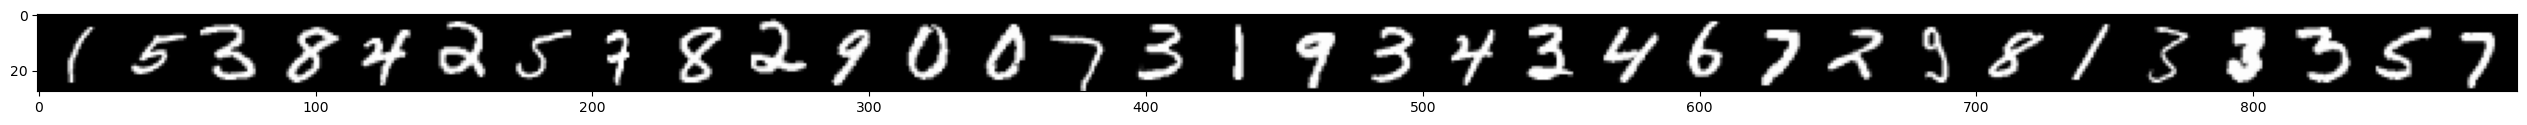

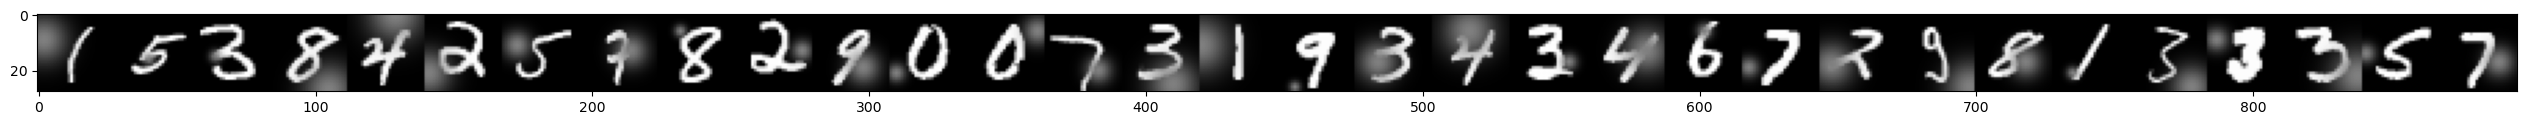

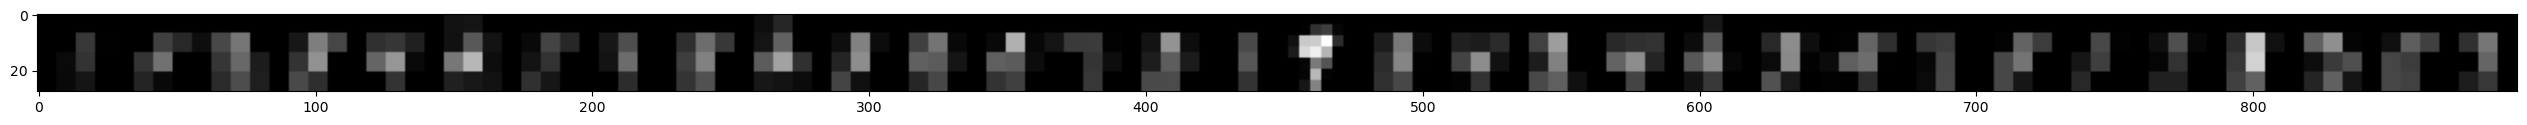

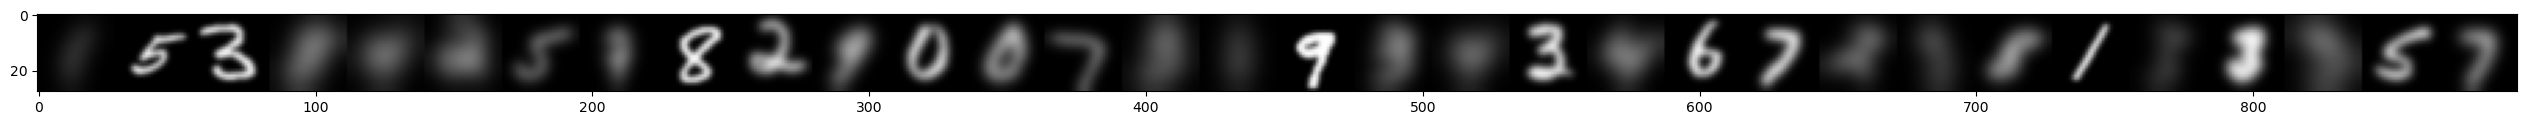

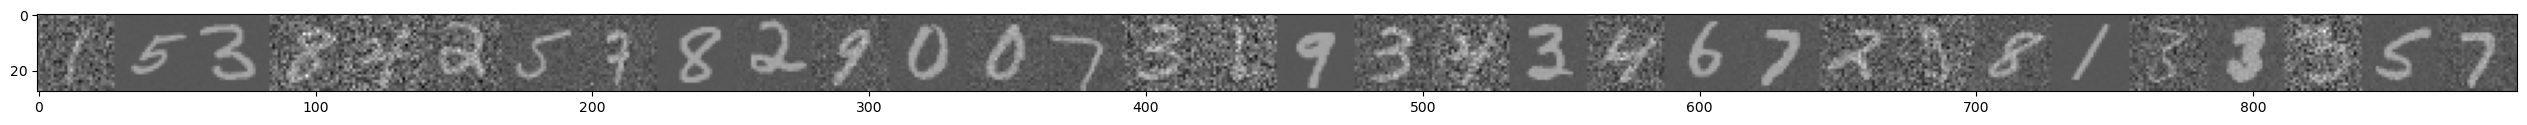

In [15]:
for x, _ in train_loader:
    x = x.to(device)
    t = diffusion.sample_timesteps(x.shape[0])
    print(t,t.shape)
    # Plot the images
    plot_images(x)
    x_t = diffusion.inpainting(x, t)
    plot_images(x_t)
    x_t = diffusion.pixellate(x, t)
    plot_images(x_t)
    x_t = diffusion.blur(x, t)
    plot_images(x_t)
    #x_t = diffusion.snow(x)
    #plot_images(x_t)
    x_t = diffusion.gaussian_noise(x, t)
    plot_images(x_t)
    
    break

tensor([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
        54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93]) torch.Size([32])


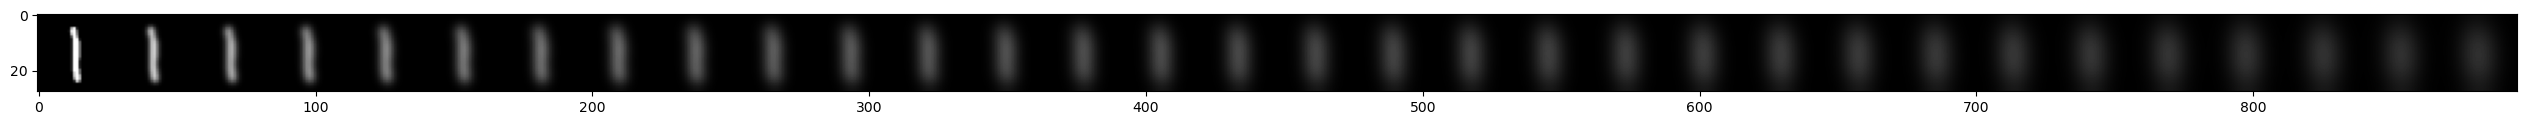

In [16]:
# Visualize one image degraded to n time steps

factor = steps// batch_size

time_steps = range(0, steps, factor)
time_steps = time_steps[:batch_size]
t = torch.tensor(time_steps).to(device)
print(t,t.shape)
for x, _ in train_loader:
    # Repeat the same image
    x = x[0].unsqueeze(0).repeat(batch_size, 1, 1, 1).to(device)
    x_t = diffusion.degradation(x, t)
    plot_images(x_t)
    break

# Visualize the degradation level per time step linearly

In [17]:
def psnr(original, degraded):
    # Convert tensors to numpy arrays if needed
    if torch.is_tensor(original):
        original = original.detach().cpu().numpy()
    if torch.is_tensor(degraded):
        degraded = degraded.detach().cpu().numpy()
        
    # Ensure same shape
    #print(original.shape, degraded.shape)
    assert original.shape == degraded.shape, "Images must have same dimensions"
    
    mse = np.mean((original - degraded) ** 2)
    if mse == 0:
        return float('inf')
    
    # Assume images are normalized to [0,1] range
    PIXEL_MAX = 1.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

tensor([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
        54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93])


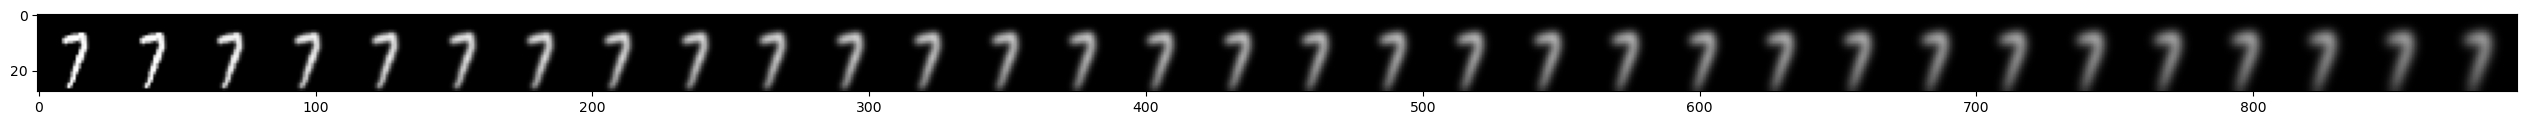

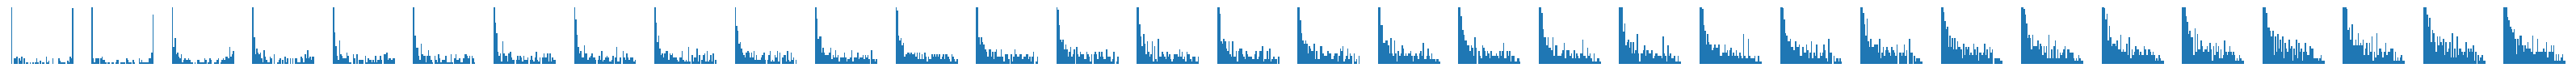

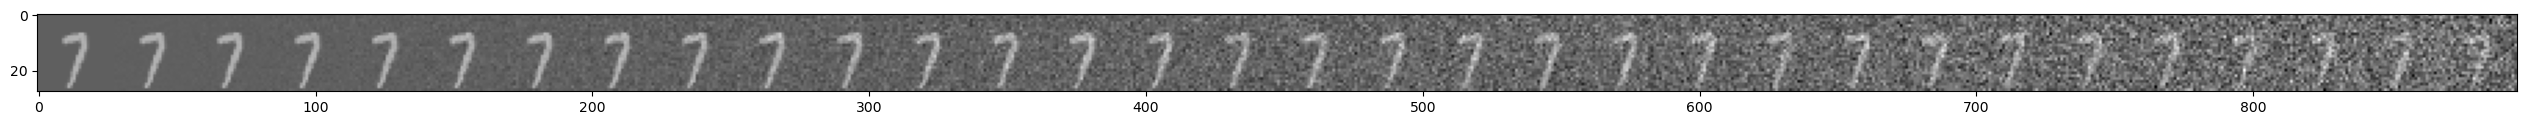

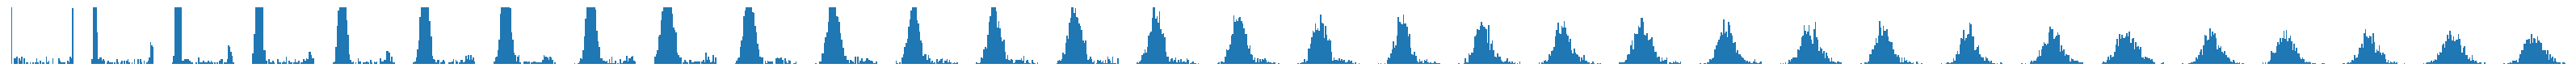

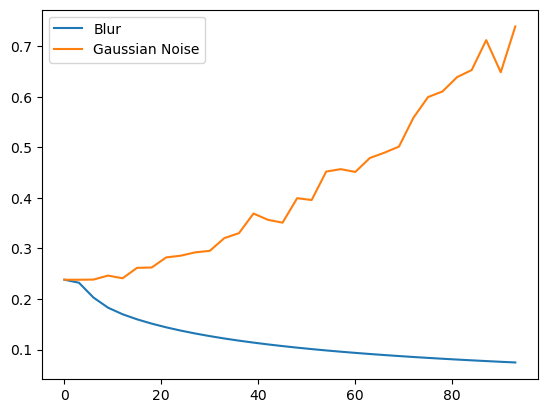

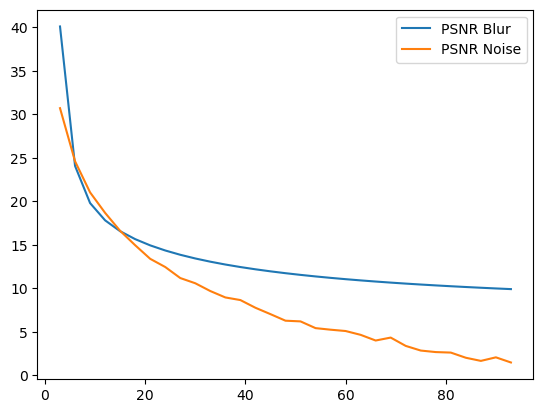

In [18]:
factor = steps// batch_size
time_steps = range(0, steps, factor)
time_steps = time_steps[:batch_size]

t = torch.tensor(time_steps).to(device)
print(t)
for x, _ in train_loader:
    x = x[0]
    x = x.unsqueeze(0).repeat(batch_size, 1, 1, 1).to(device)

    x_t = diffusion.blur(x, t,base_sigma=0.2)
    variance_blur = torch.var(x_t, dim=(1,2,3))
    psnr_blur = []
    for i in range(batch_size):
        psnr_blur.append(psnr(x[0], x_t[i]))
    plot_images(x_t)
    plot_histograms(x_t)

    x_t = diffusion.gaussian_noise(x, t)
    variance_noise = torch.var(x_t, dim=(1,2,3))
    psnr_noise = []
    for i in range(batch_size):
        psnr_noise.append(psnr(x[0], x_t[i]))
    plot_images(x_t)
    plot_histograms(x_t)

    plt.plot(time_steps, variance_blur, label='Blur')
    plt.plot(time_steps, variance_noise, label='Gaussian Noise')
    plt.legend()
    plt.show()
    plt.plot(time_steps, psnr_blur, label='PSNR Blur')
    plt.plot(time_steps, psnr_noise, label='PSNR Noise')
    plt.legend()
    plt.show()
    break

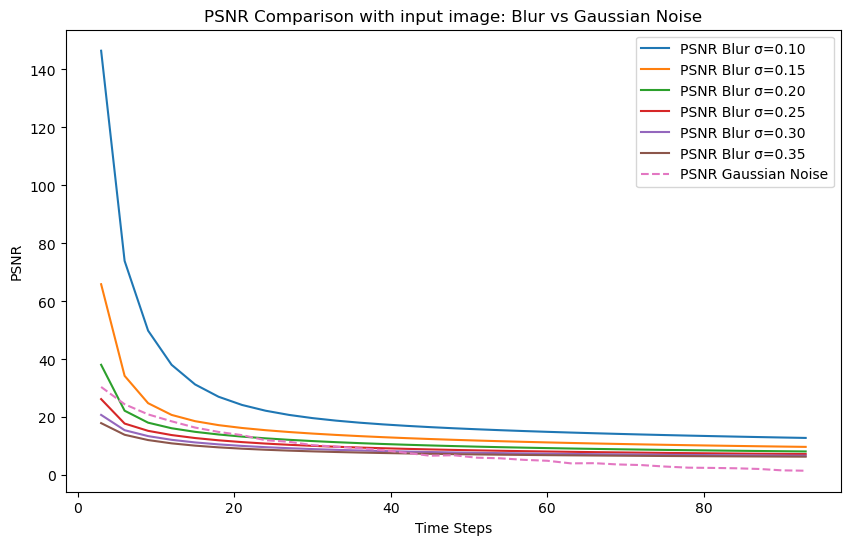

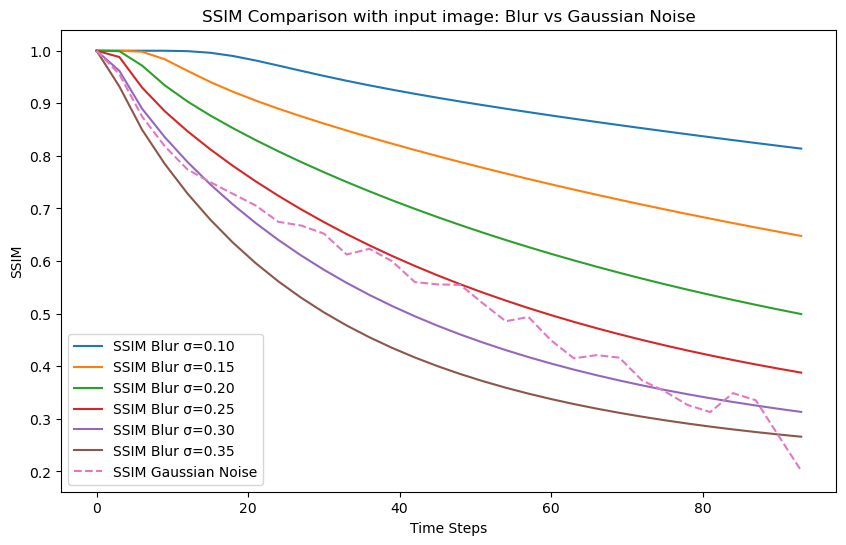

In [19]:
from skimage.metrics import structural_similarity as ssim

factor = steps// batch_size
time_steps = range(0, steps, factor)
time_steps = time_steps[:batch_size]
blur_sigmas = [x/20 for x in range(2,8,1)]
t = torch.tensor(time_steps).to(device)
for x, _ in train_loader:
    x = x[0]
    x = x.unsqueeze(0).repeat(batch_size, 1, 1, 1).to(device)

    all_psnr_blur = []
    all_ssim_blur = []
    for j in blur_sigmas:
        psnr_blur = []
        ssim_blur = []
        x_t = diffusion.blur(x, t,base_sigma=j)
        for i in range(batch_size):
            psnr_blur.append(psnr(x[0], x_t[i]))
            x_0_numpy = x[0].unsqueeze(0).cpu().numpy()[0][0]
            x_t_numpy = x_t[i].unsqueeze(0).cpu().numpy()[0][0]
            data_range = x_0_numpy.max() - x_0_numpy.min()

            ssim_blur.append(ssim(x_0_numpy, x_t_numpy,data_range=data_range))

        all_psnr_blur.append(psnr_blur)
        all_ssim_blur.append(ssim_blur)

    x_t = diffusion.gaussian_noise(x, t)
    psnr_noise = []
    ssim_noise = []
    for i in range(batch_size):
        psnr_noise.append(psnr(x[0], x_t[i]))
        x_0_numpy = x[0].unsqueeze(0).cpu().numpy()[0][0]
        x_t_numpy = x_t[i].unsqueeze(0).cpu().numpy()[0][0]
        data_range = x_0_numpy.max() - x_0_numpy.min()
        ssim_noise.append(ssim(x_0_numpy, x_t_numpy,data_range=data_range))
    
    # Plot PSNR values
    plt.figure(figsize=(10,6))
    for idx, sigma in enumerate(blur_sigmas):
        plt.plot(time_steps, all_psnr_blur[idx], label=f'PSNR Blur σ={sigma:.2f}')
    plt.plot(time_steps, psnr_noise, label='PSNR Gaussian Noise', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('PSNR')
    plt.title('PSNR Comparison with input image: Blur vs Gaussian Noise')
    plt.legend()
    plt.show()

    # Plot SSIM values  
    plt.figure(figsize=(10,6))
    for idx, sigma in enumerate(blur_sigmas):
        plt.plot(time_steps, all_ssim_blur[idx], label=f'SSIM Blur σ={sigma:.2f}')
    plt.plot(time_steps, ssim_noise, label='SSIM Gaussian Noise', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('SSIM')
    plt.title('SSIM Comparison with input image: Blur vs Gaussian Noise') 
    plt.legend()
    plt.show()
    
    break

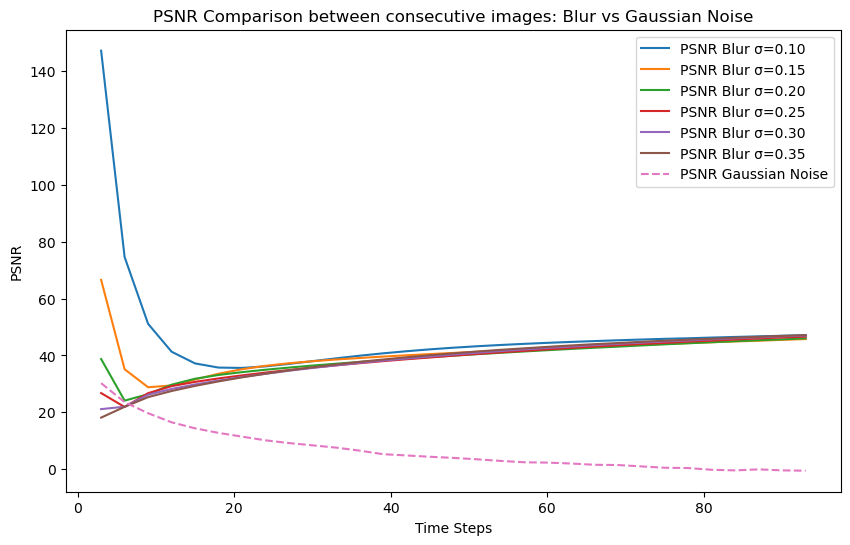

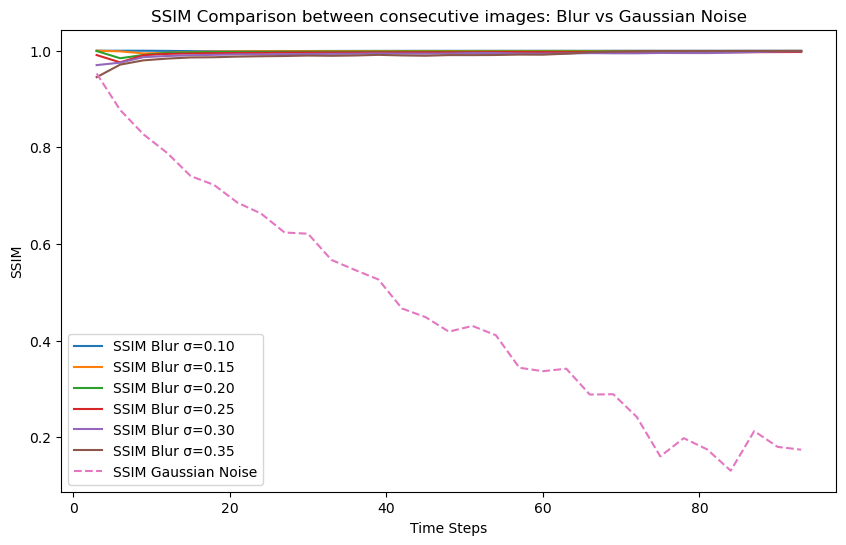

In [20]:
factor = steps// batch_size
time_steps = range(0, steps, factor)
time_steps = time_steps[:batch_size]
blur_sigmas = [x/20 for x in range(2,8,1)]
t = torch.tensor(time_steps).to(device)
for x, _ in train_loader:
    x = x[0]
    x = x.unsqueeze(0).repeat(batch_size, 1, 1, 1).to(device)

    all_psnr_blur = []
    all_ssim_blur = []
    for j in blur_sigmas:
        psnr_blur = []
        ssim_blur = []
        x_t = diffusion.blur(x, t, base_sigma=j)
        for i in range(1, batch_size):
            psnr_blur.append(psnr(x_t[i-1], x_t[i]))
            x_prev_numpy = x_t[i-1].unsqueeze(0).cpu().numpy()[0][0]
            x_curr_numpy = x_t[i].unsqueeze(0).cpu().numpy()[0][0]
            data_range = x_prev_numpy.max() - x_prev_numpy.min()
            ssim_blur.append(ssim(x_prev_numpy, x_curr_numpy, data_range=data_range))

        all_psnr_blur.append(psnr_blur)
        all_ssim_blur.append(ssim_blur)

    x_t = diffusion.gaussian_noise(x, t)
    psnr_noise = []
    ssim_noise = []
    for i in range(1, batch_size):
        psnr_noise.append(psnr(x_t[i-1], x_t[i]))
        x_prev_numpy = x_t[i-1].unsqueeze(0).cpu().numpy()[0][0]
        x_curr_numpy = x_t[i].unsqueeze(0).cpu().numpy()[0][0]
        data_range = x_prev_numpy.max() - x_prev_numpy.min()
        ssim_noise.append(ssim(x_prev_numpy, x_curr_numpy, data_range=data_range))
    
    # Plot PSNR values for different blur sigmas and noise
    plt.figure(figsize=(10,6))
    for idx, sigma in enumerate(blur_sigmas):
        plt.plot(time_steps[1:], all_psnr_blur[idx], label=f'PSNR Blur σ={sigma:.2f}')
    plt.plot(time_steps[1:], psnr_noise, label='PSNR Gaussian Noise', linestyle='--')
    plt.xlabel('Time Steps') 
    plt.ylabel('PSNR')
    plt.title('PSNR Comparison between consecutive images: Blur vs Gaussian Noise')
    plt.legend()
    plt.show()

    # Plot SSIM values for different blur sigmas and noise
    plt.figure(figsize=(10,6))
    for idx, sigma in enumerate(blur_sigmas):
        plt.plot(time_steps[1:], all_ssim_blur[idx], label=f'SSIM Blur σ={sigma:.2f}')
    plt.plot(time_steps[1:], ssim_noise, label='SSIM Gaussian Noise', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('SSIM')
    plt.title('SSIM Comparison between consecutive images: Blur vs Gaussian Noise')
    plt.legend()
    plt.show()
    
    break

# Fit a GMM to the dataset (for the blur degradation)

In [75]:
FIT_GMM = True

if FIT_GMM:
    all_blurred = []

    for x, _ in train_loader:
        x = x.to(device)
        batch_size_t = x.size(0)
        
        t = torch.full((batch_size_t,), steps).long().to(device)  # Full degradation (T steps)
        x_blurred = diffusion.degradation(x, t)
        
        all_blurred.append(x_blurred.cpu())

    # Stack all blurred images
    all_blurred = torch.cat(all_blurred, dim=0)  # shape: [N, 1, 28, 28]
    all_blurred = all_blurred.squeeze(1)  # [N, 28, 28]

    all_blurred.shape

In [76]:
if FIT_GMM:

    X = all_blurred.reshape(all_blurred.shape[0], -1)  # [N, 784]

    X.shape

In [77]:
import joblib
from sklearn.mixture import GaussianMixture

if FIT_GMM:

    

    # Choose number of components (1–5 is usually enough for MNIST)
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
    gmm.fit(X.numpy())  # convert to numpy

    # Save the GMM model
    print("Saving GMM model")
    joblib.dump(gmm, 'gmm_model_steps100_sigma1.pkl')

else:
# Load the GMM model
    print("Loading GMM model")
    gmm = joblib.load('gmm_model_steps100_sigma1.pkl')
    print(gmm)

Saving GMM model


(32, 784)


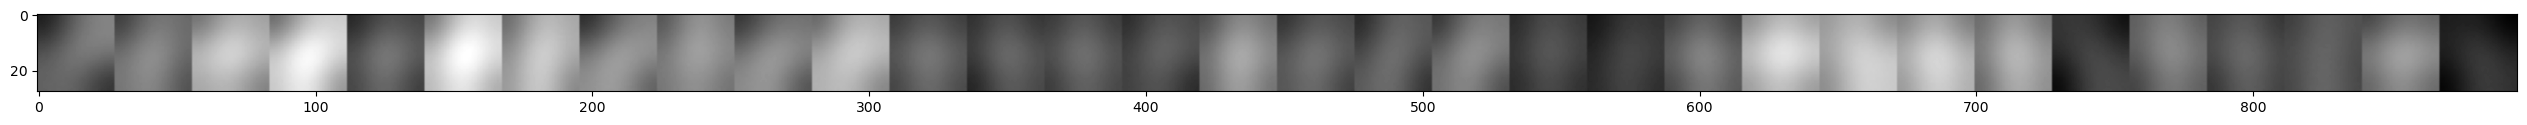

In [78]:
# Sample new points from the GMM
samples, _ = gmm.sample(batch_size)  # shape [batch_size, 784]

print(samples.shape)

torch.from_numpy(samples).view(batch_size, 1, 28, 28).shape  # Reshape to [batch_size, 1, 28, 28]

# Reshape back into images
samples = torch.from_numpy(samples).float().view(batch_size, 1, 28, 28).to(device)

# Now use samples as initial x_T
x_prev = samples

# Plot the generated images
plot_images(x_prev)

# Training

In [79]:
from torch.utils.tensorboard import SummaryWriter
import shutil
import os

DELETE_PREVIOUS_RUN = False

run_name = f'coldDiffusion_{degradation_type}_s{steps}_b{batch_size}_{sampling_type}_{learning_rate:.1e}_e{EPOCHS}_{loss_type}_{len(dataset)}'
if scheduler is not None:
    run_name += f'_scheduler_{scheduler.__class__.__name__}'

if DELETE_PREVIOUS_RUN:
    # Delete the previous run folder if it exists
    if os.path.exists('runs/' + run_name):
        shutil.rmtree('runs/' + run_name)
        print(f"Deleted previous run folder: runs/{run_name}")

else:
    # Add a version number to the run name if it already exists
    version = 1
    while os.path.exists('runs/' + run_name):
        run_name = f'coldDiffusion_{degradation_type}_s{steps}_b{batch_size}_{sampling_type}_{learning_rate:.1e}_e{EPOCHS}_{loss_type}_{len(dataset)}'
        if scheduler is not None:
            run_name += f'_scheduler_{scheduler.__class__.__name__}'
        run_name += f'_v{version}'
        version += 1



writer = SummaryWriter('runs/' + run_name)
print(run_name)

coldDiffusion_blur_s100_b32_gmm_5.0e-05_e100_L1_6000_scheduler_ReduceLROnPlateau


In [80]:
# Cuda clear cache
import gc
gc.collect()
torch.cuda.empty_cache()

Epoch  0


100%|██████████| 188/188 [00:31<00:00,  5.95it/s]


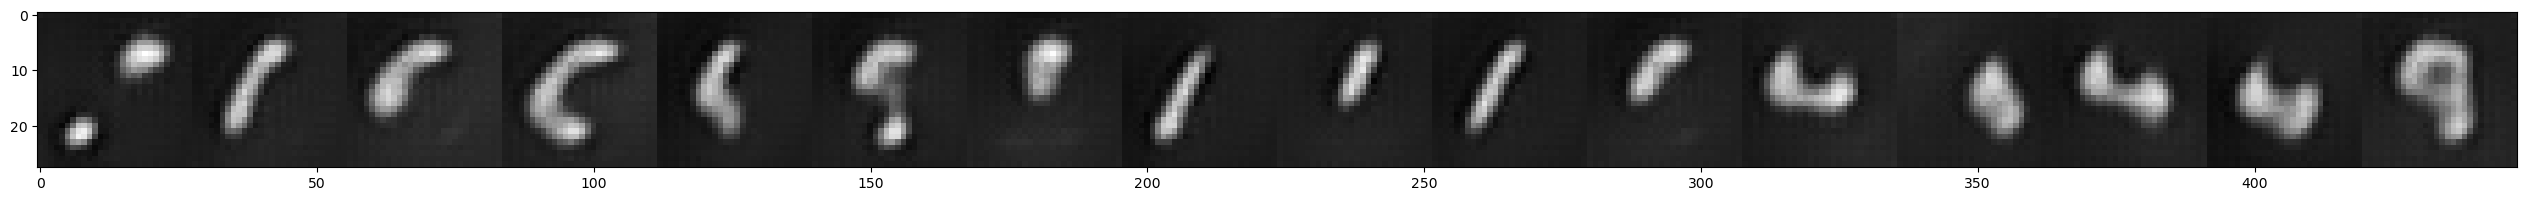

Epoch [1/100] | Train Loss: 0.2647 | Validation Loss: 0.2032 | Learning Rate: 0.0000500000
Epoch  1


100%|██████████| 188/188 [00:31<00:00,  5.93it/s]


Epoch [2/100] | Train Loss: 0.1769 | Validation Loss: 0.1499 | Learning Rate: 0.0000500000
Epoch  2


100%|██████████| 188/188 [00:31<00:00,  5.98it/s]


Epoch [3/100] | Train Loss: 0.1484 | Validation Loss: 0.1300 | Learning Rate: 0.0000500000
Epoch  3


100%|██████████| 188/188 [00:31<00:00,  5.88it/s]


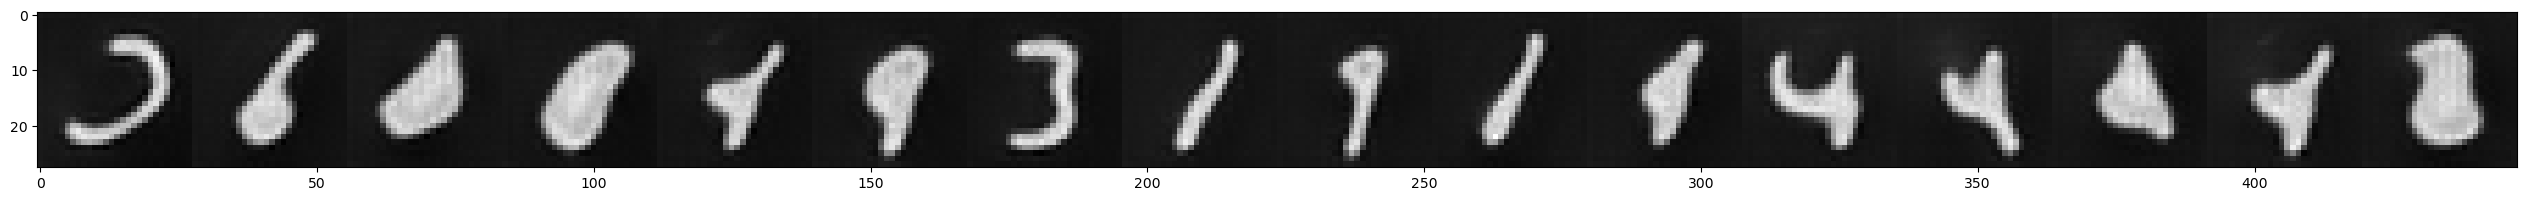

Epoch [4/100] | Train Loss: 0.1341 | Validation Loss: 0.1311 | Learning Rate: 0.0000500000
Epoch  4


100%|██████████| 188/188 [00:32<00:00,  5.86it/s]


Epoch [5/100] | Train Loss: 0.1236 | Validation Loss: 0.1201 | Learning Rate: 0.0000500000
Epoch  5


100%|██████████| 188/188 [00:31<00:00,  5.90it/s]


Epoch [6/100] | Train Loss: 0.1161 | Validation Loss: 0.1076 | Learning Rate: 0.0000500000
Epoch  6


100%|██████████| 188/188 [00:31<00:00,  5.88it/s]


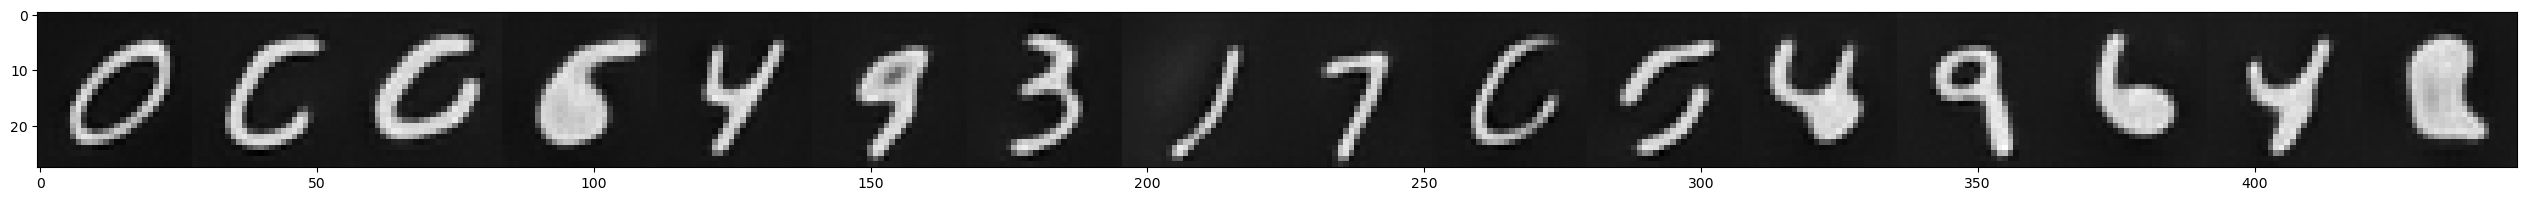

Epoch [7/100] | Train Loss: 0.1118 | Validation Loss: 0.1031 | Learning Rate: 0.0000500000
Epoch  7


100%|██████████| 188/188 [00:31<00:00,  5.92it/s]


Epoch [8/100] | Train Loss: 0.1094 | Validation Loss: 0.1032 | Learning Rate: 0.0000500000
Epoch  8


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]


Epoch [9/100] | Train Loss: 0.1036 | Validation Loss: 0.1019 | Learning Rate: 0.0000500000
Epoch  9


100%|██████████| 188/188 [00:32<00:00,  5.87it/s]


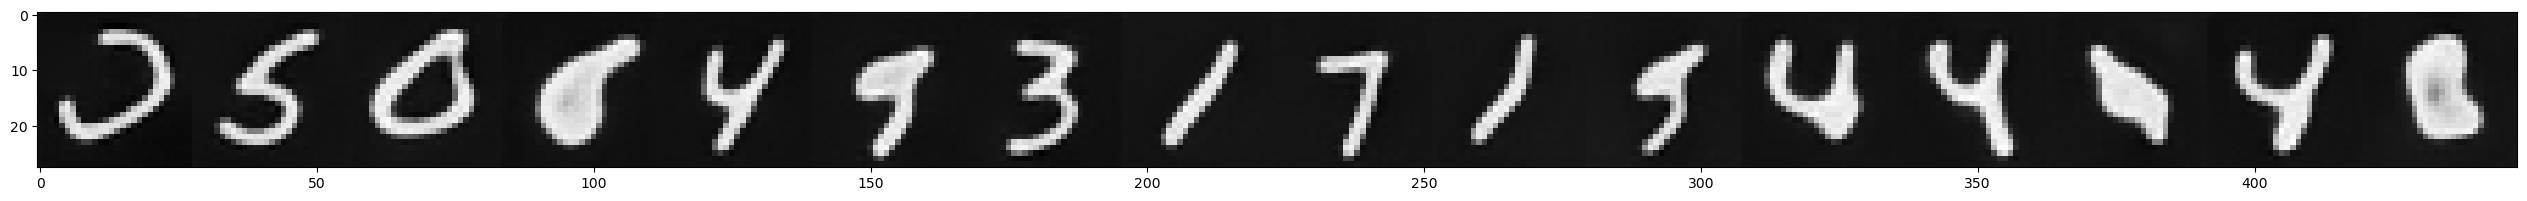

Epoch [10/100] | Train Loss: 0.1008 | Validation Loss: 0.0902 | Learning Rate: 0.0000500000
Epoch  10


100%|██████████| 188/188 [00:32<00:00,  5.82it/s]


Epoch [11/100] | Train Loss: 0.0964 | Validation Loss: 0.0925 | Learning Rate: 0.0000500000
Epoch  11


100%|██████████| 188/188 [00:31<00:00,  5.88it/s]


Epoch [12/100] | Train Loss: 0.0971 | Validation Loss: 0.0932 | Learning Rate: 0.0000500000
Epoch  12


100%|██████████| 188/188 [00:31<00:00,  5.92it/s]


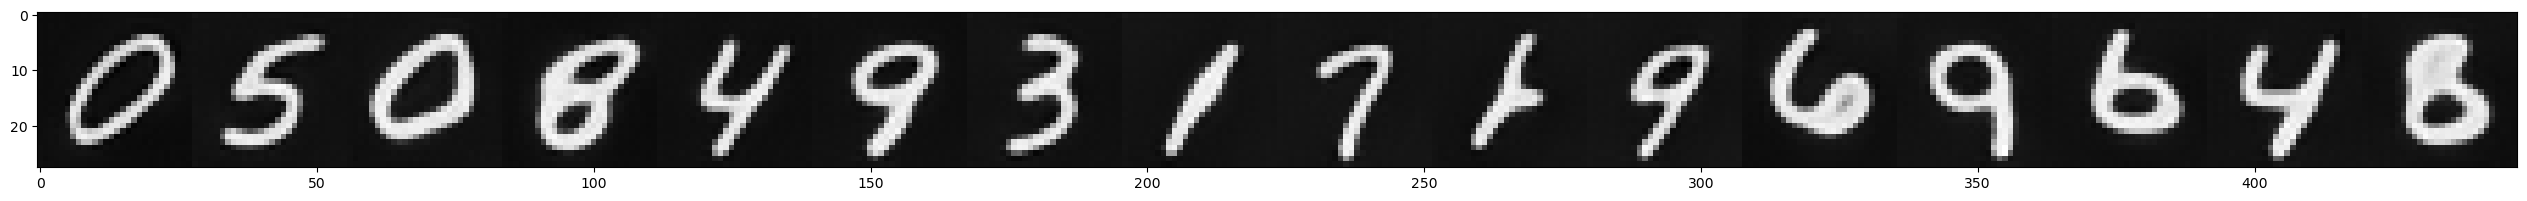

Epoch [13/100] | Train Loss: 0.0949 | Validation Loss: 0.0925 | Learning Rate: 0.0000500000
Epoch  13


100%|██████████| 188/188 [00:31<00:00,  5.92it/s]


Epoch [14/100] | Train Loss: 0.0914 | Validation Loss: 0.0853 | Learning Rate: 0.0000500000
Epoch  14


100%|██████████| 188/188 [00:32<00:00,  5.81it/s]


Epoch [15/100] | Train Loss: 0.0884 | Validation Loss: 0.0861 | Learning Rate: 0.0000500000
Epoch  15


100%|██████████| 188/188 [00:32<00:00,  5.80it/s]


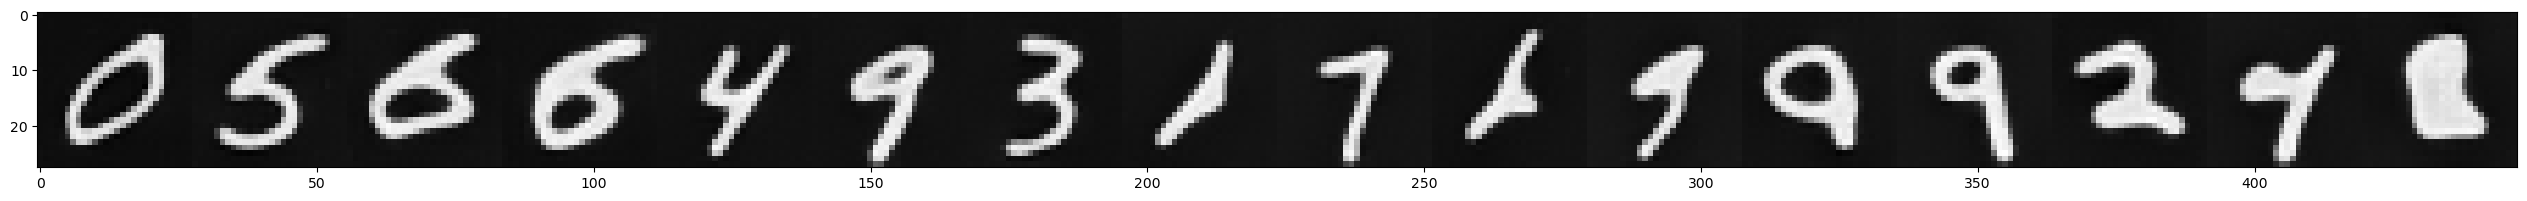

Epoch [16/100] | Train Loss: 0.0882 | Validation Loss: 0.0825 | Learning Rate: 0.0000500000
Epoch  16


100%|██████████| 188/188 [00:31<00:00,  5.88it/s]


Epoch [17/100] | Train Loss: 0.0883 | Validation Loss: 0.0865 | Learning Rate: 0.0000500000
Epoch  17


100%|██████████| 188/188 [00:32<00:00,  5.83it/s]


Epoch [18/100] | Train Loss: 0.0862 | Validation Loss: 0.0829 | Learning Rate: 0.0000500000
Epoch  18


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]


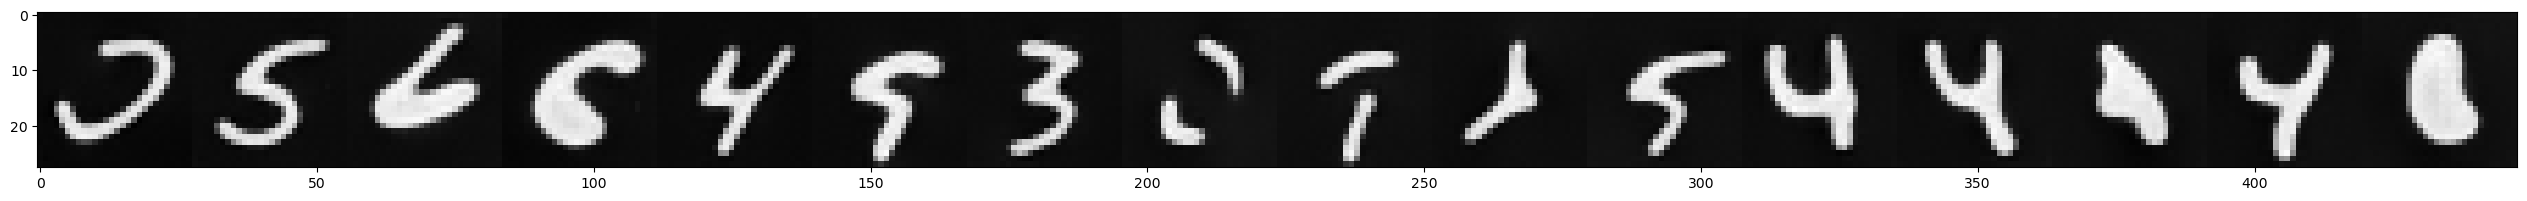

Epoch [19/100] | Train Loss: 0.0862 | Validation Loss: 0.0840 | Learning Rate: 0.0000500000
Epoch  19


100%|██████████| 188/188 [00:31<00:00,  5.88it/s]


Epoch [20/100] | Train Loss: 0.0833 | Validation Loss: 0.0982 | Learning Rate: 0.0000500000
Epoch  20


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]


Epoch [21/100] | Train Loss: 0.0843 | Validation Loss: 0.0780 | Learning Rate: 0.0000500000
Epoch  21


100%|██████████| 188/188 [00:31<00:00,  5.91it/s]


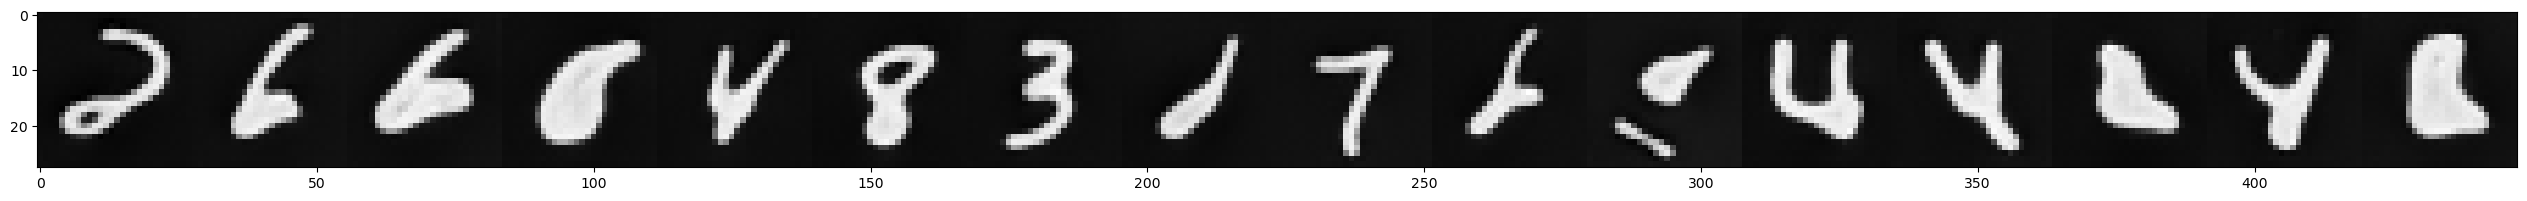

Epoch [22/100] | Train Loss: 0.0807 | Validation Loss: 0.0783 | Learning Rate: 0.0000500000
Epoch  22


100%|██████████| 188/188 [00:31<00:00,  5.96it/s]


Epoch [23/100] | Train Loss: 0.0831 | Validation Loss: 0.0754 | Learning Rate: 0.0000500000
Epoch  23


100%|██████████| 188/188 [00:31<00:00,  5.90it/s]


Epoch [24/100] | Train Loss: 0.0808 | Validation Loss: 0.0795 | Learning Rate: 0.0000500000
Epoch  24


100%|██████████| 188/188 [00:31<00:00,  5.88it/s]


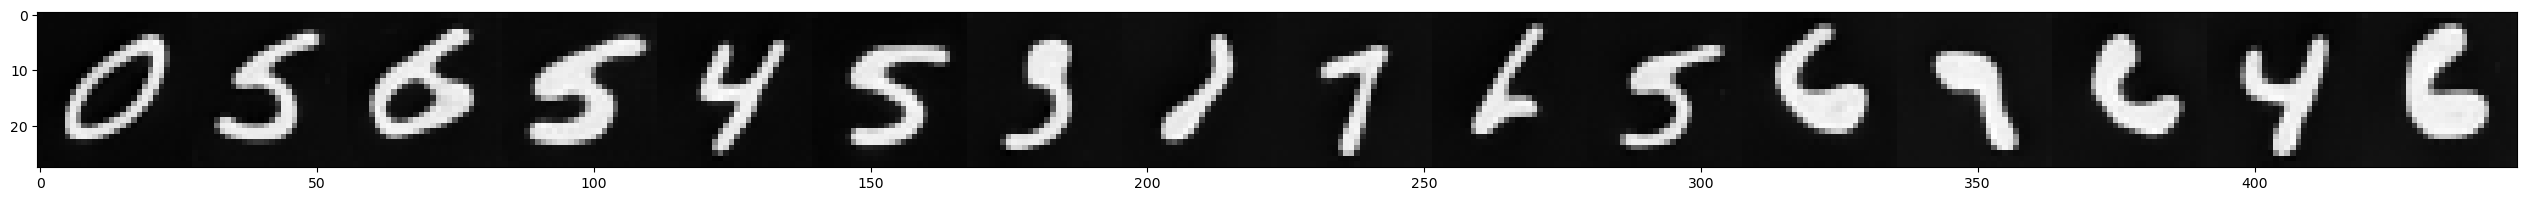

Epoch [25/100] | Train Loss: 0.0800 | Validation Loss: 0.0767 | Learning Rate: 0.0000500000
Epoch  25


100%|██████████| 188/188 [00:32<00:00,  5.80it/s]


Epoch [26/100] | Train Loss: 0.0782 | Validation Loss: 0.0752 | Learning Rate: 0.0000500000
Epoch  26


100%|██████████| 188/188 [00:32<00:00,  5.86it/s]


Epoch [27/100] | Train Loss: 0.0774 | Validation Loss: 0.0743 | Learning Rate: 0.0000500000
Epoch  27


100%|██████████| 188/188 [00:31<00:00,  5.90it/s]


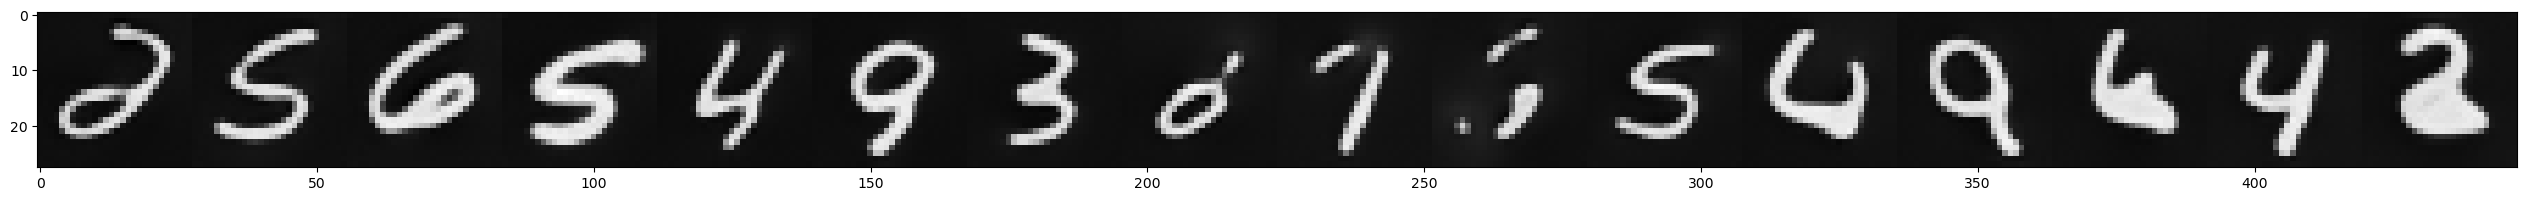

Epoch [28/100] | Train Loss: 0.0769 | Validation Loss: 0.0731 | Learning Rate: 0.0000500000
Epoch  28


100%|██████████| 188/188 [00:32<00:00,  5.80it/s]


Epoch [29/100] | Train Loss: 0.0762 | Validation Loss: 0.0721 | Learning Rate: 0.0000500000
Epoch  29


100%|██████████| 188/188 [00:32<00:00,  5.78it/s]


Epoch [30/100] | Train Loss: 0.0759 | Validation Loss: 0.0725 | Learning Rate: 0.0000500000
Epoch  30


100%|██████████| 188/188 [00:32<00:00,  5.81it/s]


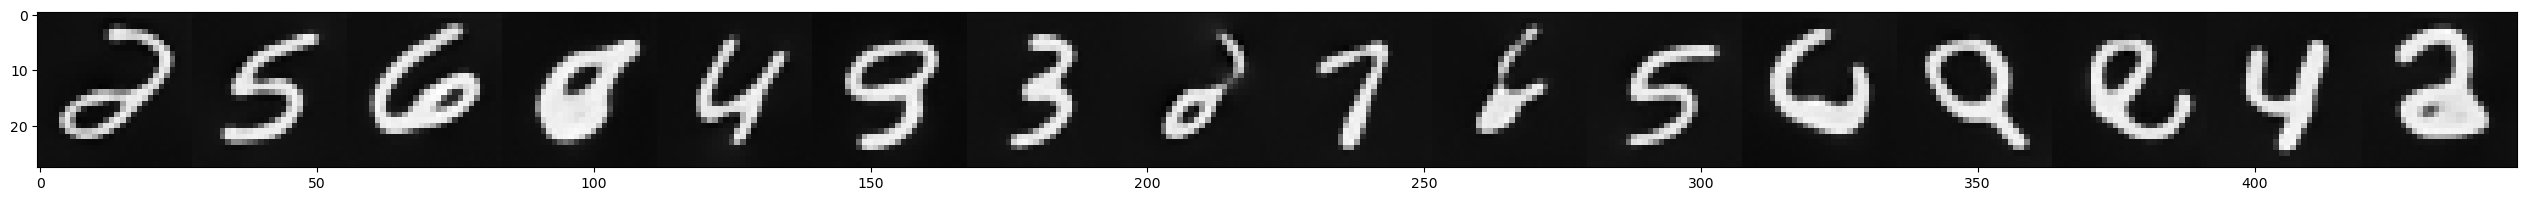

Epoch [31/100] | Train Loss: 0.0750 | Validation Loss: 0.0716 | Learning Rate: 0.0000500000
Epoch  31


100%|██████████| 188/188 [00:32<00:00,  5.76it/s]


Epoch [32/100] | Train Loss: 0.0738 | Validation Loss: 0.0699 | Learning Rate: 0.0000500000
Epoch  32


100%|██████████| 188/188 [00:32<00:00,  5.79it/s]


Epoch [33/100] | Train Loss: 0.0744 | Validation Loss: 0.0699 | Learning Rate: 0.0000500000
Epoch  33


100%|██████████| 188/188 [00:32<00:00,  5.78it/s]


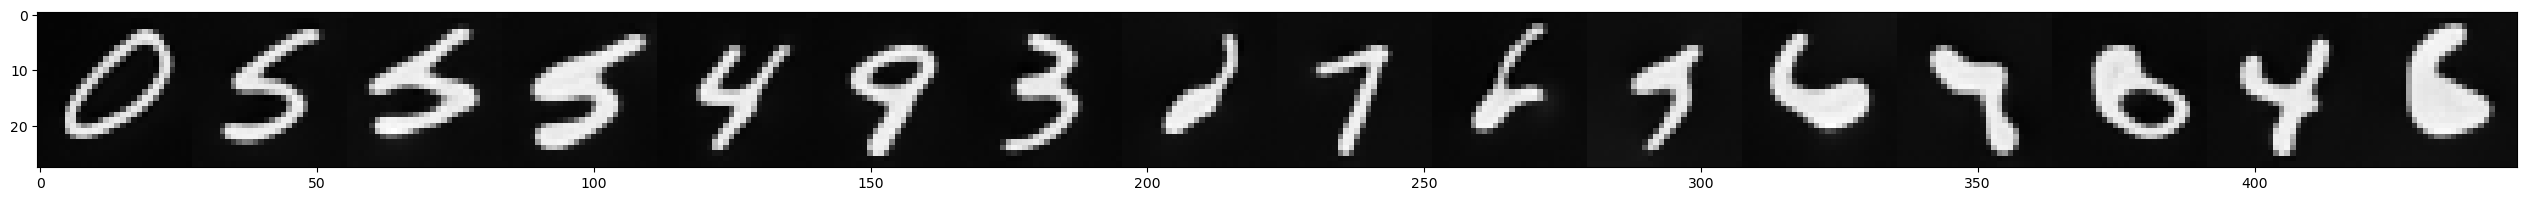

Epoch [34/100] | Train Loss: 0.0722 | Validation Loss: 0.0672 | Learning Rate: 0.0000500000
Epoch  34


100%|██████████| 188/188 [00:32<00:00,  5.74it/s]


Epoch [35/100] | Train Loss: 0.0737 | Validation Loss: 0.0711 | Learning Rate: 0.0000500000
Epoch  35


100%|██████████| 188/188 [00:32<00:00,  5.84it/s]


Epoch [36/100] | Train Loss: 0.0716 | Validation Loss: 0.0724 | Learning Rate: 0.0000500000
Epoch  36


100%|██████████| 188/188 [00:32<00:00,  5.79it/s]


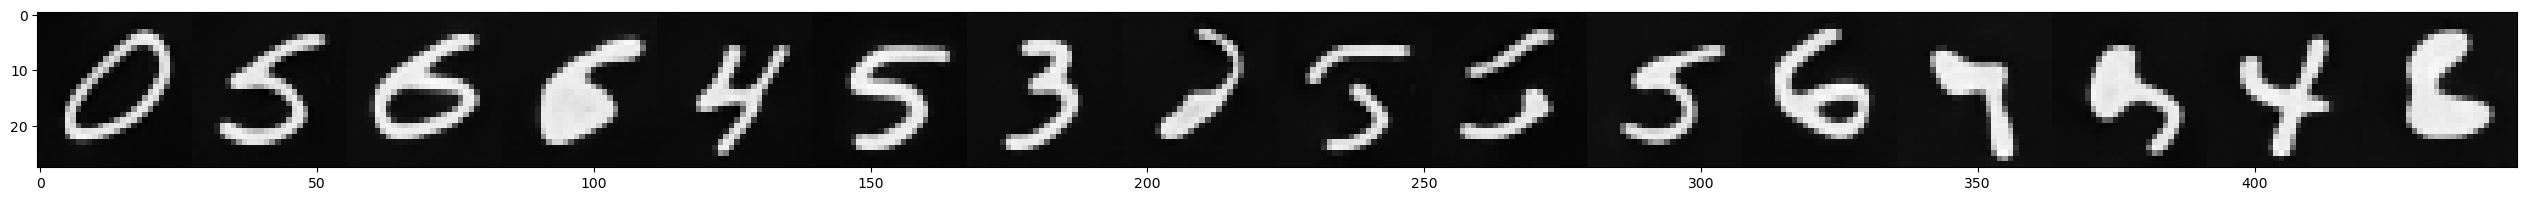

Epoch [37/100] | Train Loss: 0.0718 | Validation Loss: 0.0655 | Learning Rate: 0.0000500000
Epoch  37


100%|██████████| 188/188 [00:32<00:00,  5.79it/s]


Epoch [38/100] | Train Loss: 0.0724 | Validation Loss: 0.0708 | Learning Rate: 0.0000500000
Epoch  38


100%|██████████| 188/188 [00:32<00:00,  5.84it/s]


Epoch [39/100] | Train Loss: 0.0705 | Validation Loss: 0.0665 | Learning Rate: 0.0000500000
Epoch  39


100%|██████████| 188/188 [00:31<00:00,  5.89it/s]


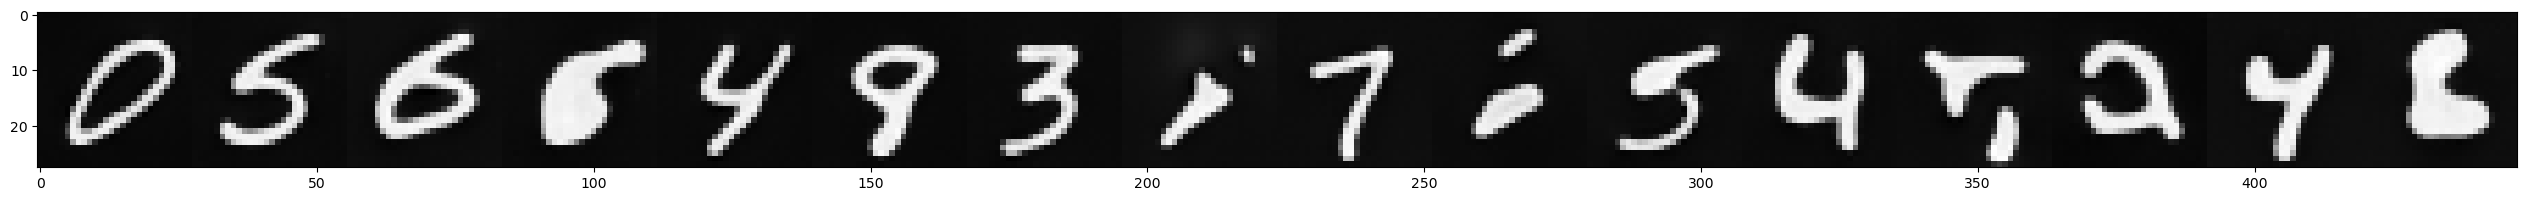

Epoch [40/100] | Train Loss: 0.0703 | Validation Loss: 0.0682 | Learning Rate: 0.0000500000
Epoch  40


100%|██████████| 188/188 [00:32<00:00,  5.75it/s]


Epoch [41/100] | Train Loss: 0.0690 | Validation Loss: 0.0647 | Learning Rate: 0.0000500000
Epoch  41


100%|██████████| 188/188 [00:32<00:00,  5.87it/s]


Epoch [42/100] | Train Loss: 0.0682 | Validation Loss: 0.0745 | Learning Rate: 0.0000500000
Epoch  42


100%|██████████| 188/188 [00:31<00:00,  6.00it/s]


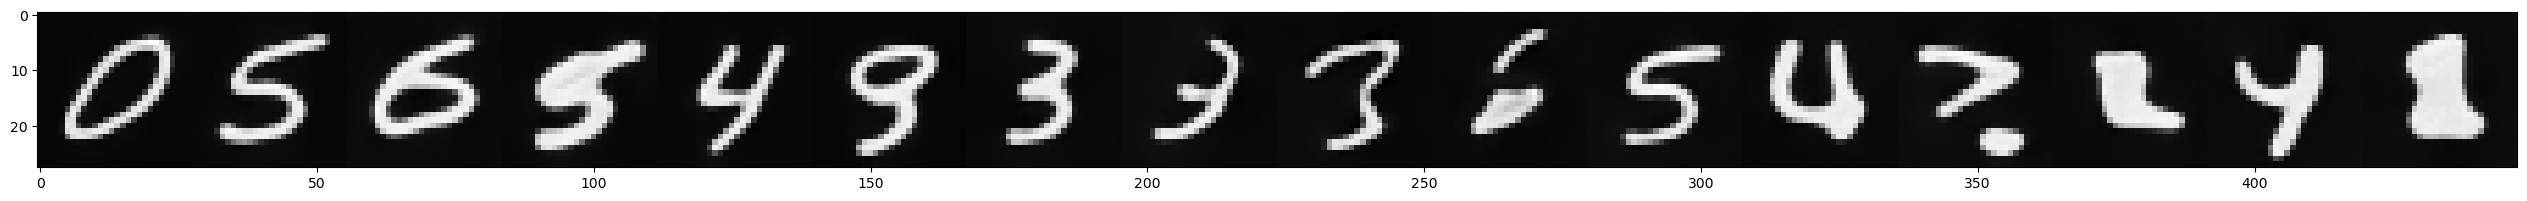

Epoch [43/100] | Train Loss: 0.0690 | Validation Loss: 0.0673 | Learning Rate: 0.0000500000
Epoch  43


100%|██████████| 188/188 [00:31<00:00,  5.95it/s]


Epoch [44/100] | Train Loss: 0.0686 | Validation Loss: 0.0656 | Learning Rate: 0.0000500000
Epoch  44


100%|██████████| 188/188 [00:31<00:00,  5.97it/s]


Epoch [45/100] | Train Loss: 0.0676 | Validation Loss: 0.0682 | Learning Rate: 0.0000500000
Epoch  45


100%|██████████| 188/188 [00:31<00:00,  5.98it/s]


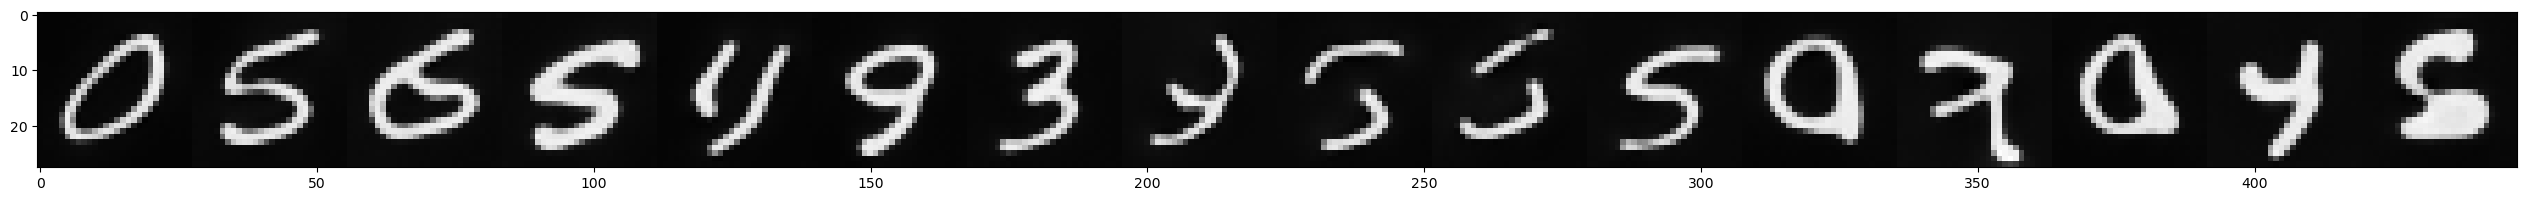

Epoch [46/100] | Train Loss: 0.0666 | Validation Loss: 0.0680 | Learning Rate: 0.0000500000
Epoch  46


100%|██████████| 188/188 [00:31<00:00,  5.94it/s]


Epoch [47/100] | Train Loss: 0.0666 | Validation Loss: 0.0626 | Learning Rate: 0.0000500000
Epoch  47


100%|██████████| 188/188 [00:31<00:00,  5.99it/s]


Epoch [48/100] | Train Loss: 0.0658 | Validation Loss: 0.0635 | Learning Rate: 0.0000500000
Epoch  48


100%|██████████| 188/188 [00:31<00:00,  5.98it/s]


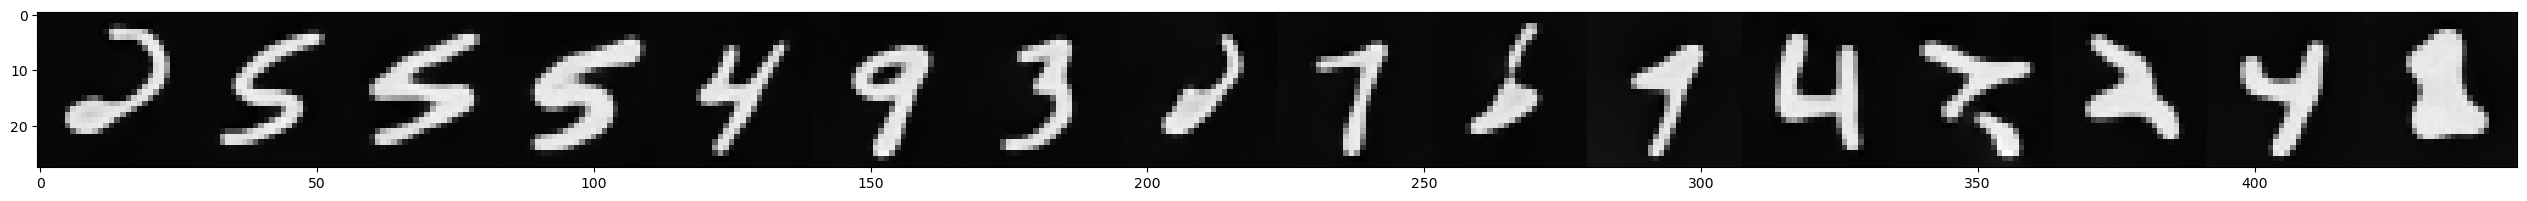

Epoch [49/100] | Train Loss: 0.0671 | Validation Loss: 0.0659 | Learning Rate: 0.0000500000
Epoch  49


100%|██████████| 188/188 [00:31<00:00,  6.01it/s]


Epoch [50/100] | Train Loss: 0.0668 | Validation Loss: 0.0610 | Learning Rate: 0.0000500000
Epoch  50


100%|██████████| 188/188 [00:31<00:00,  5.96it/s]


Epoch [51/100] | Train Loss: 0.0655 | Validation Loss: 0.0612 | Learning Rate: 0.0000500000
Epoch  51


100%|██████████| 188/188 [00:32<00:00,  5.81it/s]


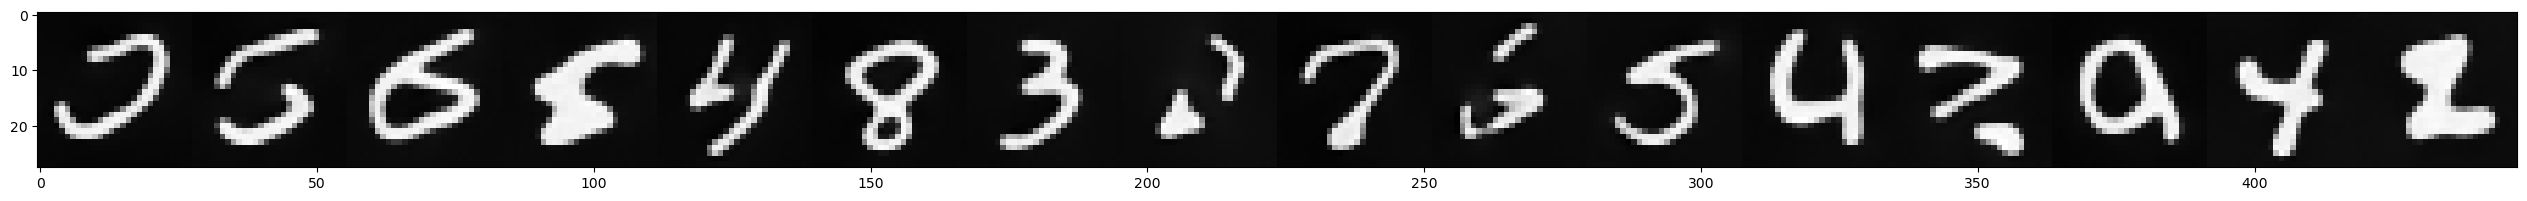

Epoch [52/100] | Train Loss: 0.0642 | Validation Loss: 0.0599 | Learning Rate: 0.0000500000
Epoch  52


100%|██████████| 188/188 [00:32<00:00,  5.83it/s]


Epoch [53/100] | Train Loss: 0.0640 | Validation Loss: 0.0627 | Learning Rate: 0.0000500000
Epoch  53


100%|██████████| 188/188 [00:32<00:00,  5.84it/s]


Epoch [54/100] | Train Loss: 0.0639 | Validation Loss: 0.0604 | Learning Rate: 0.0000500000
Epoch  54


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]


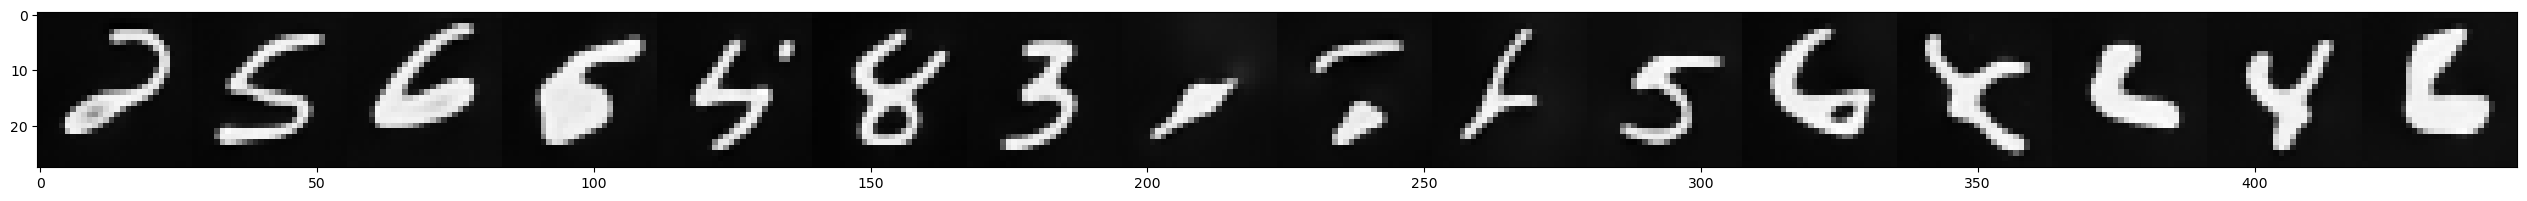

Epoch [55/100] | Train Loss: 0.0624 | Validation Loss: 0.0638 | Learning Rate: 0.0000500000
Epoch  55


100%|██████████| 188/188 [00:32<00:00,  5.84it/s]


Epoch [56/100] | Train Loss: 0.0622 | Validation Loss: 0.0641 | Learning Rate: 0.0000500000
Epoch  56


100%|██████████| 188/188 [00:32<00:00,  5.82it/s]


Epoch [57/100] | Train Loss: 0.0636 | Validation Loss: 0.0632 | Learning Rate: 0.0000500000
Epoch  57


100%|██████████| 188/188 [00:31<00:00,  5.89it/s]


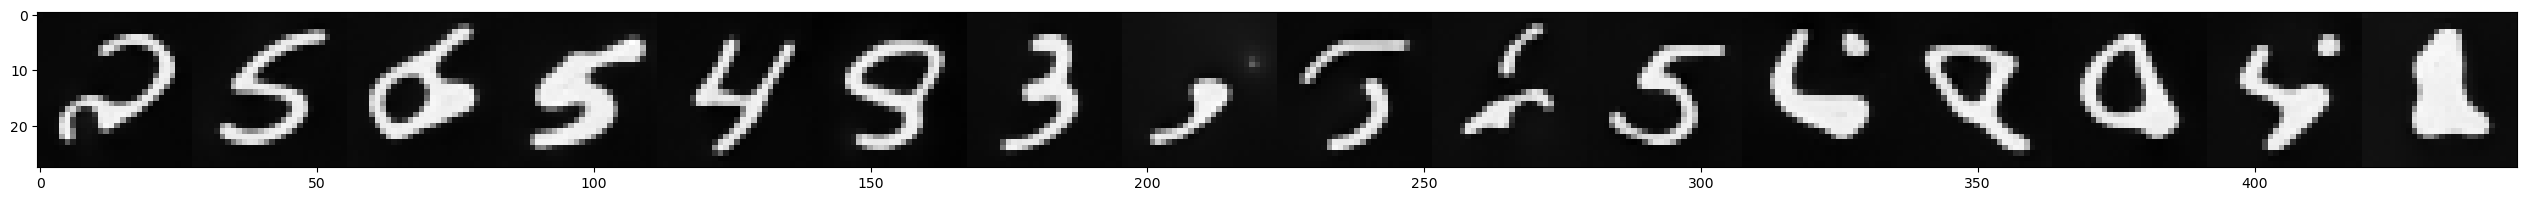

Epoch [58/100] | Train Loss: 0.0623 | Validation Loss: 0.0597 | Learning Rate: 0.0000500000
Epoch  58


100%|██████████| 188/188 [00:32<00:00,  5.84it/s]


Epoch [59/100] | Train Loss: 0.0611 | Validation Loss: 0.0586 | Learning Rate: 0.0000500000
Epoch  59


100%|██████████| 188/188 [00:32<00:00,  5.77it/s]


Epoch [60/100] | Train Loss: 0.0607 | Validation Loss: 0.0604 | Learning Rate: 0.0000500000
Epoch  60


100%|██████████| 188/188 [00:32<00:00,  5.83it/s]


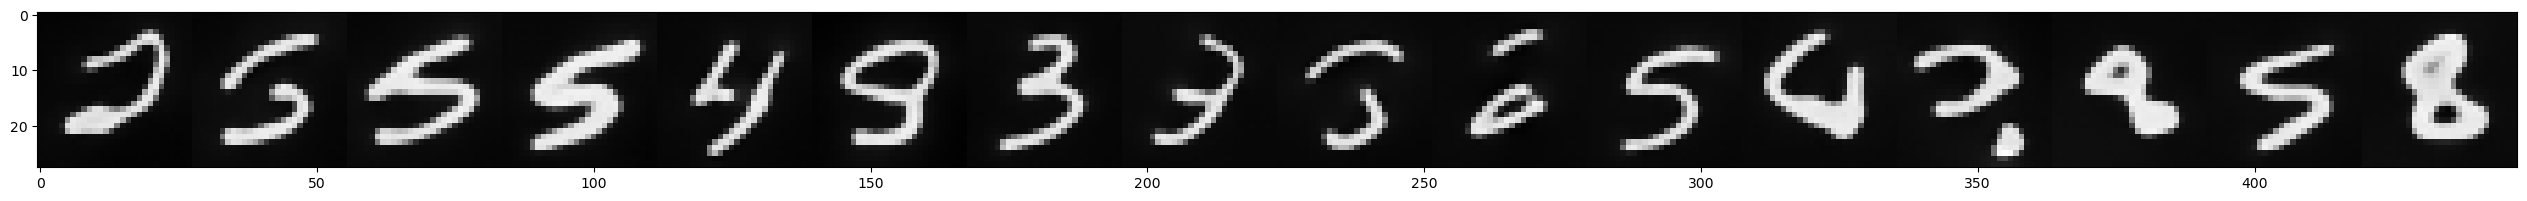

Epoch [61/100] | Train Loss: 0.0607 | Validation Loss: 0.0598 | Learning Rate: 0.0000500000
Epoch  61


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]


Epoch [62/100] | Train Loss: 0.0614 | Validation Loss: 0.0590 | Learning Rate: 0.0000500000
Epoch  62


100%|██████████| 188/188 [00:31<00:00,  5.93it/s]


Epoch [63/100] | Train Loss: 0.0610 | Validation Loss: 0.0613 | Learning Rate: 0.0000500000
Epoch  63


100%|██████████| 188/188 [00:31<00:00,  5.91it/s]


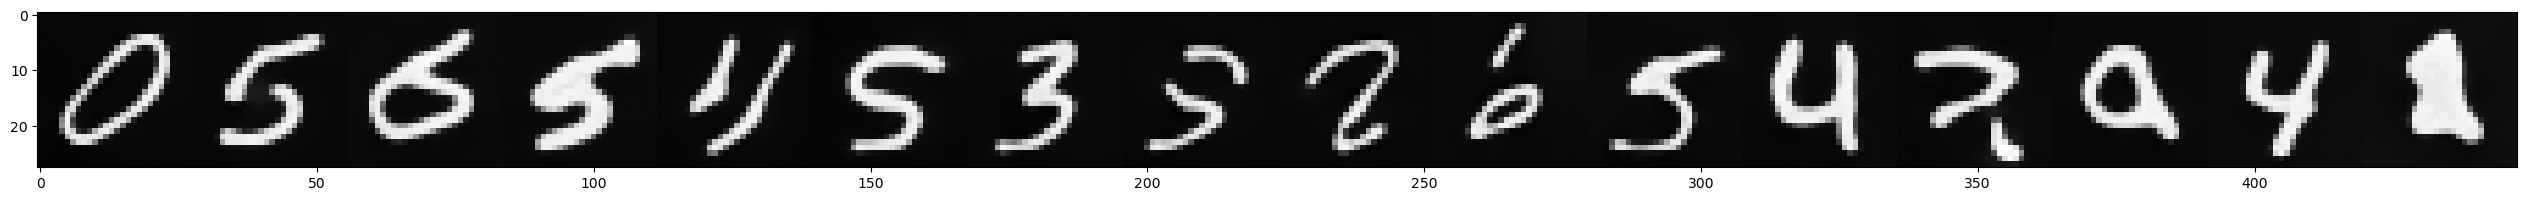

Epoch [64/100] | Train Loss: 0.0605 | Validation Loss: 0.0589 | Learning Rate: 0.0000500000
Epoch  64


100%|██████████| 188/188 [00:32<00:00,  5.86it/s]


Epoch [65/100] | Train Loss: 0.0592 | Validation Loss: 0.0598 | Learning Rate: 0.0000250000
Epoch  65


100%|██████████| 188/188 [00:31<00:00,  5.99it/s]


Epoch [66/100] | Train Loss: 0.0532 | Validation Loss: 0.0498 | Learning Rate: 0.0000250000
Epoch  66


100%|██████████| 188/188 [00:31<00:00,  5.94it/s]


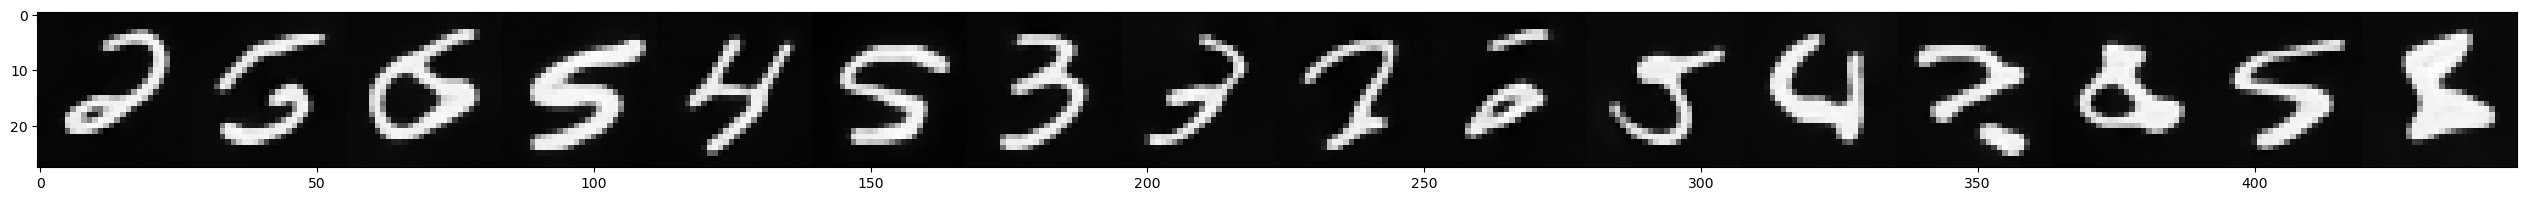

Epoch [67/100] | Train Loss: 0.0519 | Validation Loss: 0.0509 | Learning Rate: 0.0000250000
Epoch  67


100%|██████████| 188/188 [00:31<00:00,  5.95it/s]


Epoch [68/100] | Train Loss: 0.0510 | Validation Loss: 0.0484 | Learning Rate: 0.0000250000
Epoch  68


100%|██████████| 188/188 [00:31<00:00,  5.94it/s]


Epoch [69/100] | Train Loss: 0.0511 | Validation Loss: 0.0484 | Learning Rate: 0.0000250000
Epoch  69


100%|██████████| 188/188 [00:31<00:00,  5.98it/s]


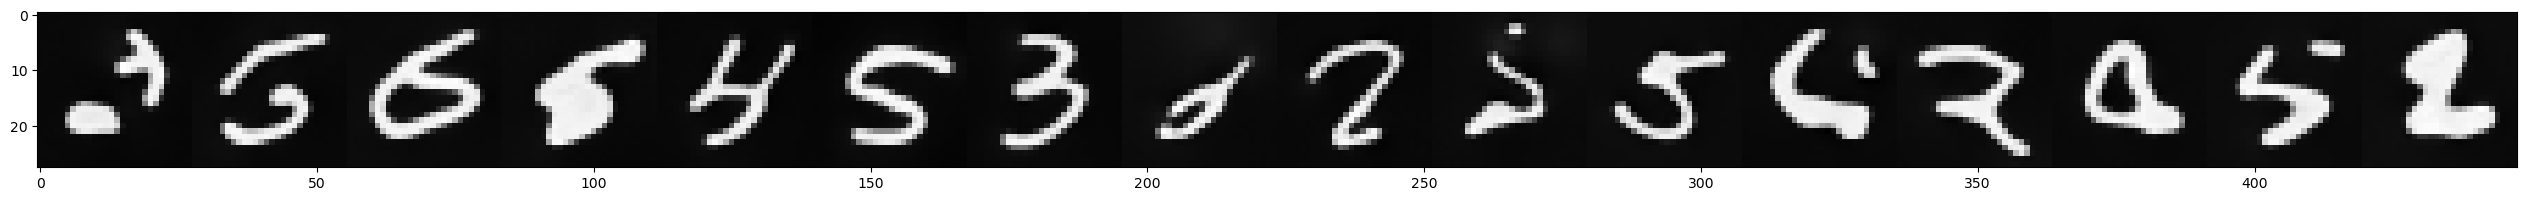

Epoch [70/100] | Train Loss: 0.0501 | Validation Loss: 0.0488 | Learning Rate: 0.0000250000
Epoch  70


100%|██████████| 188/188 [00:31<00:00,  5.97it/s]


Epoch [71/100] | Train Loss: 0.0503 | Validation Loss: 0.0482 | Learning Rate: 0.0000250000
Epoch  71


100%|██████████| 188/188 [00:31<00:00,  5.94it/s]


Epoch [72/100] | Train Loss: 0.0503 | Validation Loss: 0.0484 | Learning Rate: 0.0000250000
Epoch  72


100%|██████████| 188/188 [00:31<00:00,  5.92it/s]


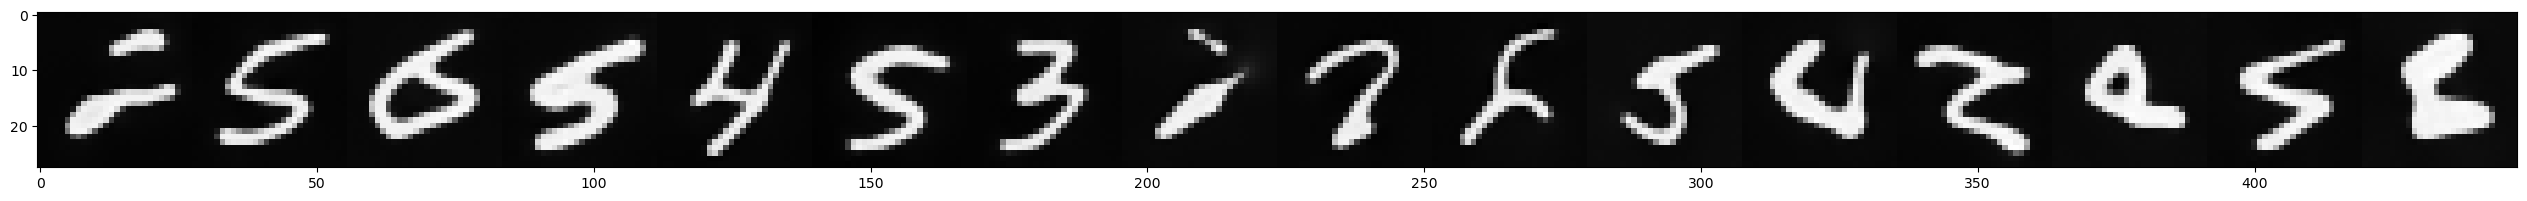

Epoch [73/100] | Train Loss: 0.0491 | Validation Loss: 0.0482 | Learning Rate: 0.0000250000
Epoch  73


100%|██████████| 188/188 [00:31<00:00,  5.95it/s]


Epoch [74/100] | Train Loss: 0.0492 | Validation Loss: 0.0483 | Learning Rate: 0.0000250000
Epoch  74


100%|██████████| 188/188 [00:31<00:00,  5.90it/s]


Epoch [75/100] | Train Loss: 0.0493 | Validation Loss: 0.0457 | Learning Rate: 0.0000250000
Epoch  75


100%|██████████| 188/188 [00:32<00:00,  5.86it/s]


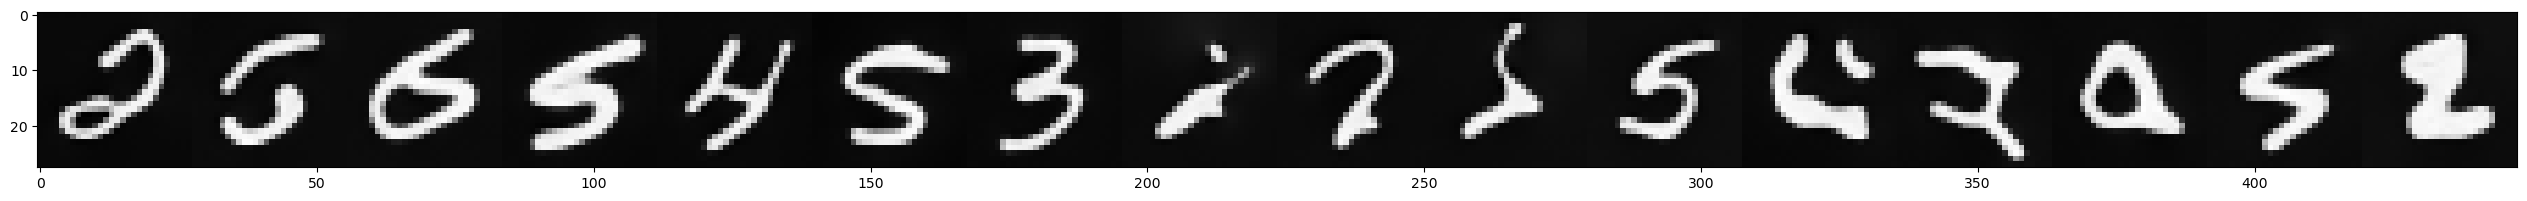

Epoch [76/100] | Train Loss: 0.0485 | Validation Loss: 0.0479 | Learning Rate: 0.0000250000
Epoch  76


100%|██████████| 188/188 [00:31<00:00,  5.93it/s]


Epoch [77/100] | Train Loss: 0.0485 | Validation Loss: 0.0470 | Learning Rate: 0.0000250000
Epoch  77


100%|██████████| 188/188 [00:31<00:00,  5.96it/s]


Epoch [78/100] | Train Loss: 0.0481 | Validation Loss: 0.0476 | Learning Rate: 0.0000250000
Epoch  78


100%|██████████| 188/188 [00:31<00:00,  5.93it/s]


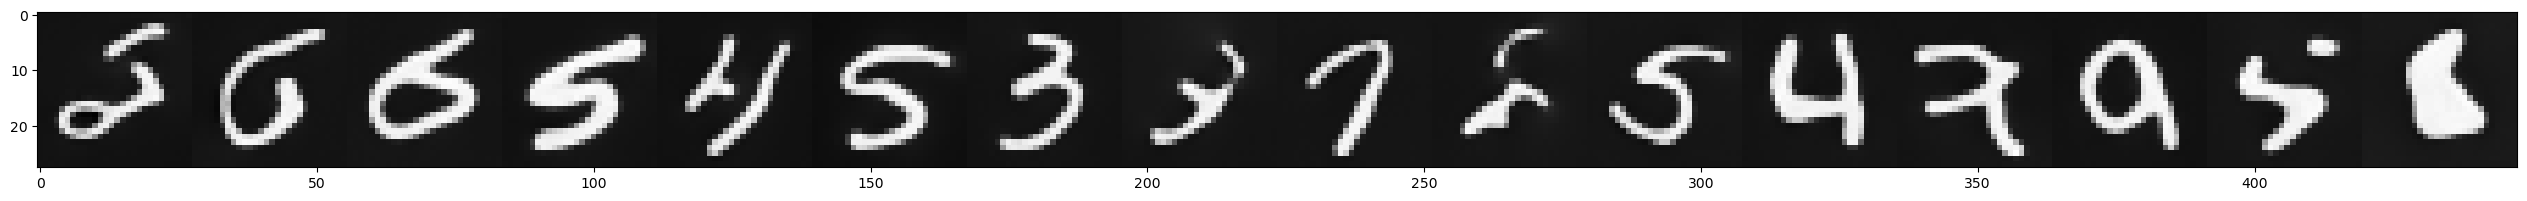

Epoch [79/100] | Train Loss: 0.0483 | Validation Loss: 0.0492 | Learning Rate: 0.0000250000
Epoch  79


100%|██████████| 188/188 [00:31<00:00,  5.97it/s]


Epoch [80/100] | Train Loss: 0.0476 | Validation Loss: 0.0463 | Learning Rate: 0.0000250000
Epoch  80


100%|██████████| 188/188 [00:31<00:00,  5.97it/s]


Epoch [81/100] | Train Loss: 0.0474 | Validation Loss: 0.0453 | Learning Rate: 0.0000250000
Epoch  81


100%|██████████| 188/188 [00:31<00:00,  5.97it/s]


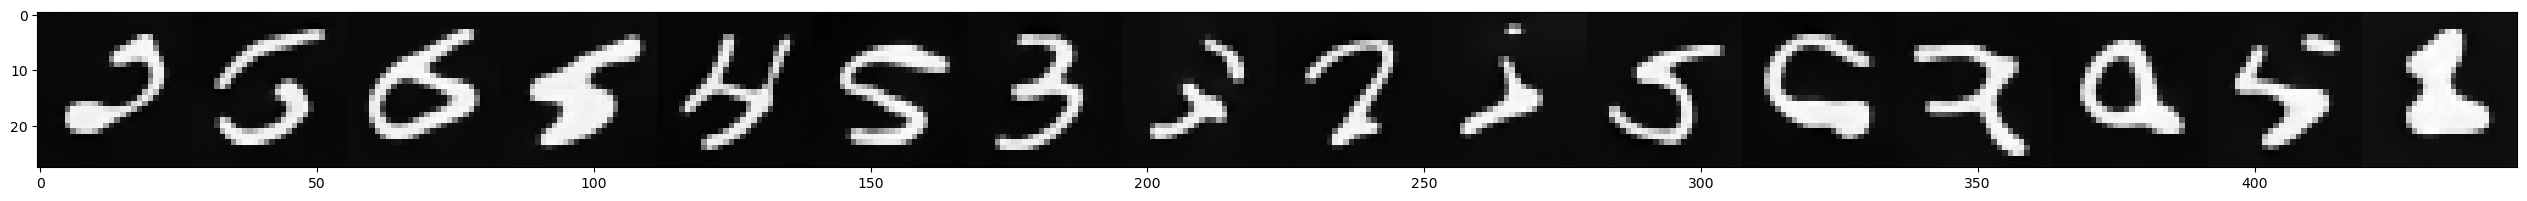

Epoch [82/100] | Train Loss: 0.0470 | Validation Loss: 0.0456 | Learning Rate: 0.0000250000
Epoch  82


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]


Epoch [83/100] | Train Loss: 0.0466 | Validation Loss: 0.0439 | Learning Rate: 0.0000250000
Epoch  83


100%|██████████| 188/188 [00:31<00:00,  5.92it/s]


Epoch [84/100] | Train Loss: 0.0466 | Validation Loss: 0.0429 | Learning Rate: 0.0000250000
Epoch  84


100%|██████████| 188/188 [00:31<00:00,  5.94it/s]


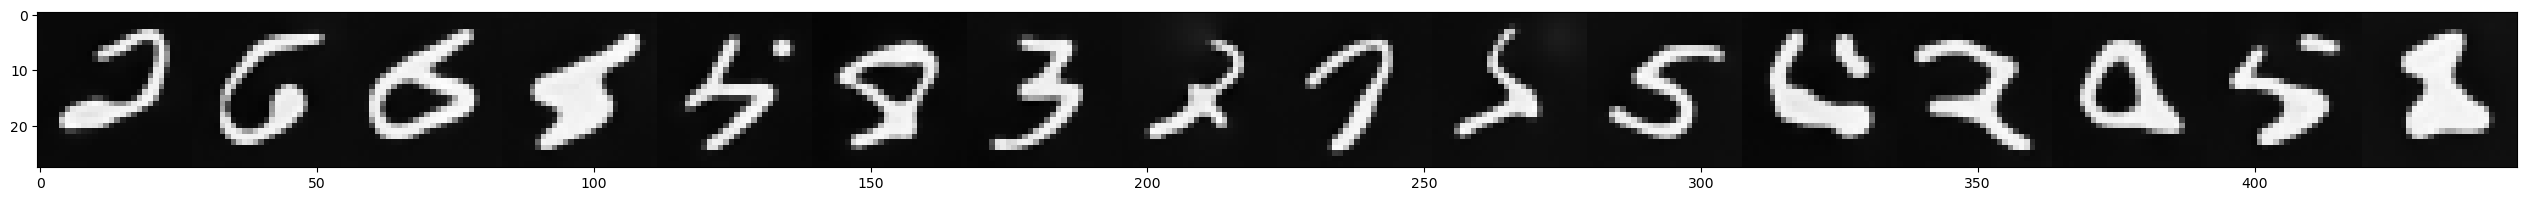

Epoch [85/100] | Train Loss: 0.0467 | Validation Loss: 0.0464 | Learning Rate: 0.0000250000
Epoch  85


100%|██████████| 188/188 [00:31<00:00,  5.89it/s]


Epoch [86/100] | Train Loss: 0.0459 | Validation Loss: 0.0441 | Learning Rate: 0.0000250000
Epoch  86


100%|██████████| 188/188 [00:31<00:00,  5.91it/s]


Epoch [87/100] | Train Loss: 0.0458 | Validation Loss: 0.0446 | Learning Rate: 0.0000250000
Epoch  87


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]


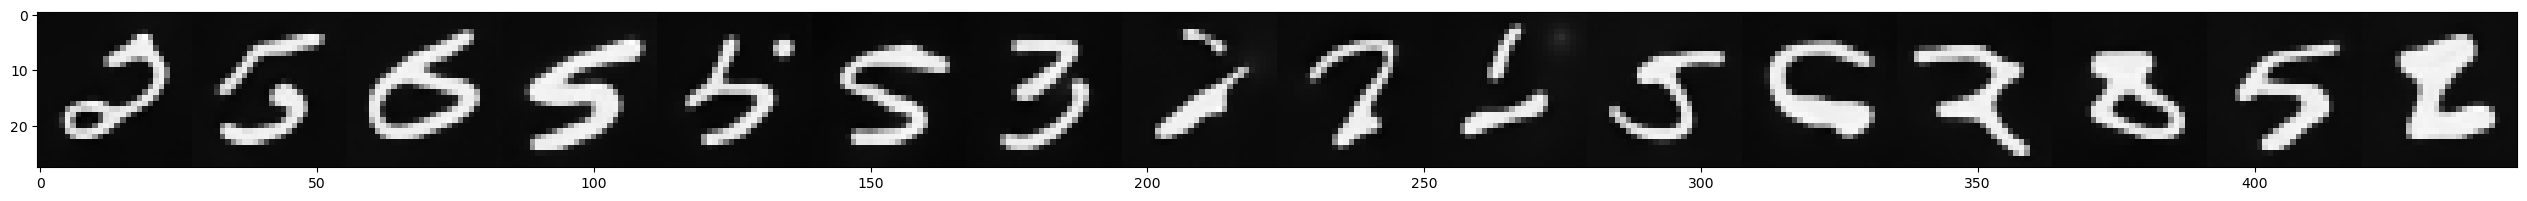

Epoch [88/100] | Train Loss: 0.0460 | Validation Loss: 0.0437 | Learning Rate: 0.0000250000
Epoch  88


100%|██████████| 188/188 [00:32<00:00,  5.84it/s]


Epoch [89/100] | Train Loss: 0.0457 | Validation Loss: 0.0425 | Learning Rate: 0.0000250000
Epoch  89


100%|██████████| 188/188 [00:31<00:00,  5.90it/s]


Epoch [90/100] | Train Loss: 0.0451 | Validation Loss: 0.0428 | Learning Rate: 0.0000250000
Epoch  90


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]


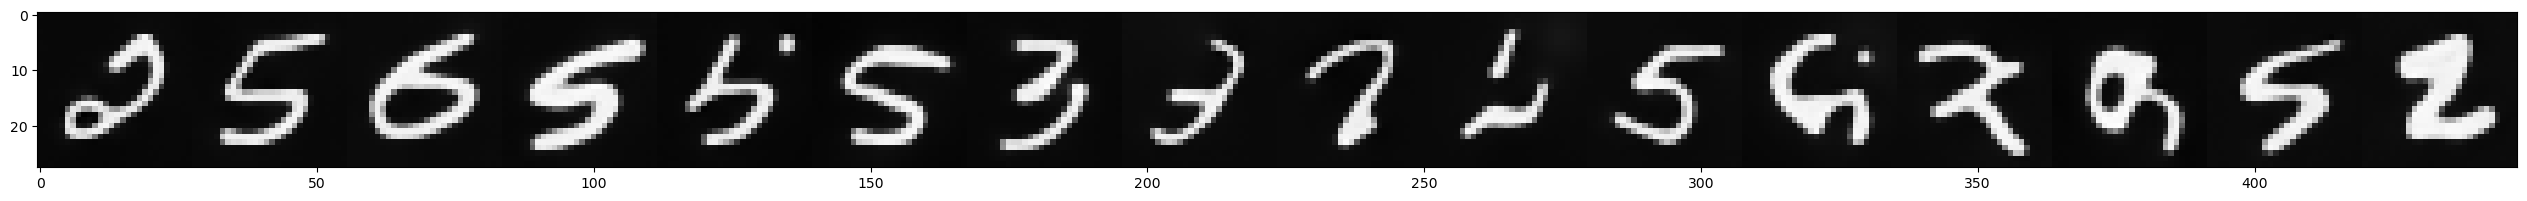

Epoch [91/100] | Train Loss: 0.0448 | Validation Loss: 0.0435 | Learning Rate: 0.0000250000
Epoch  91


100%|██████████| 188/188 [00:32<00:00,  5.77it/s]


Epoch [92/100] | Train Loss: 0.0445 | Validation Loss: 0.0443 | Learning Rate: 0.0000250000
Epoch  92


100%|██████████| 188/188 [00:31<00:00,  5.92it/s]


Epoch [93/100] | Train Loss: 0.0446 | Validation Loss: 0.0429 | Learning Rate: 0.0000250000
Epoch  93


100%|██████████| 188/188 [00:31<00:00,  5.93it/s]


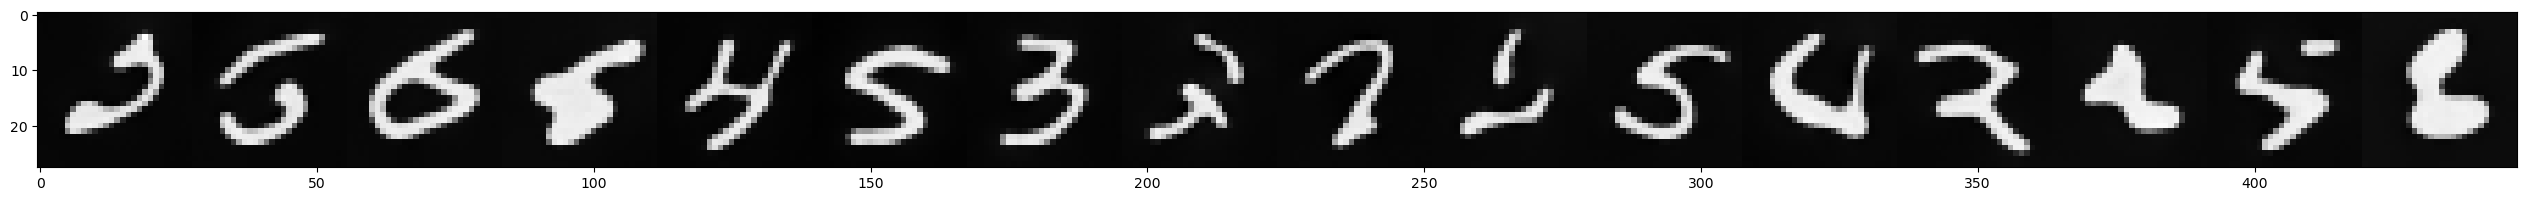

Epoch [94/100] | Train Loss: 0.0441 | Validation Loss: 0.0428 | Learning Rate: 0.0000250000
Epoch  94


100%|██████████| 188/188 [00:31<00:00,  5.95it/s]


Epoch [95/100] | Train Loss: 0.0434 | Validation Loss: 0.0419 | Learning Rate: 0.0000250000
Epoch  95


100%|██████████| 188/188 [00:31<00:00,  5.96it/s]


Epoch [96/100] | Train Loss: 0.0434 | Validation Loss: 0.0430 | Learning Rate: 0.0000250000
Epoch  96


100%|██████████| 188/188 [00:31<00:00,  5.94it/s]


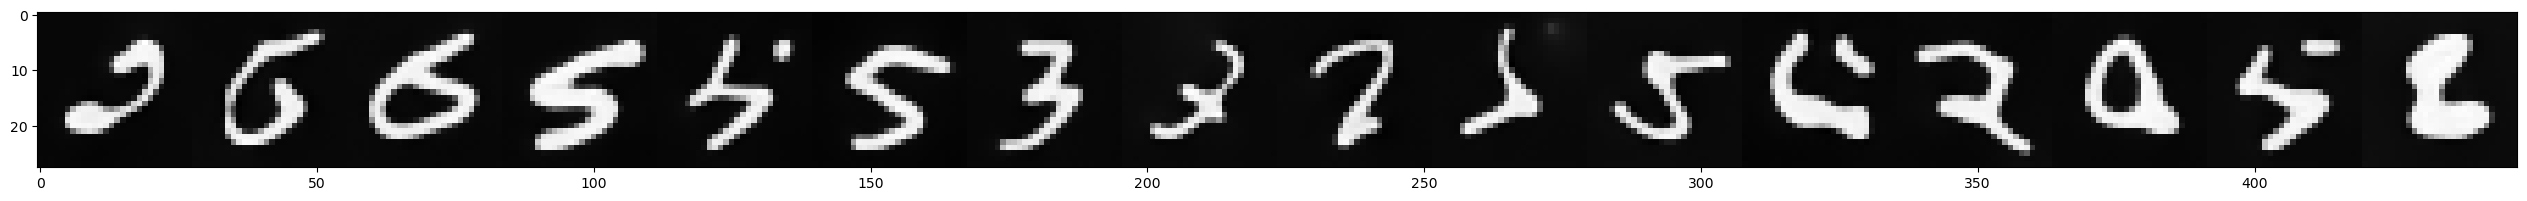

Epoch [97/100] | Train Loss: 0.0441 | Validation Loss: 0.0409 | Learning Rate: 0.0000250000
Epoch  97


100%|██████████| 188/188 [00:31<00:00,  5.97it/s]


Epoch [98/100] | Train Loss: 0.0436 | Validation Loss: 0.0415 | Learning Rate: 0.0000250000
Epoch  98


100%|██████████| 188/188 [00:31<00:00,  6.00it/s]


Epoch [99/100] | Train Loss: 0.0437 | Validation Loss: 0.0412 | Learning Rate: 0.0000250000
Epoch  99


100%|██████████| 188/188 [00:31<00:00,  5.95it/s]


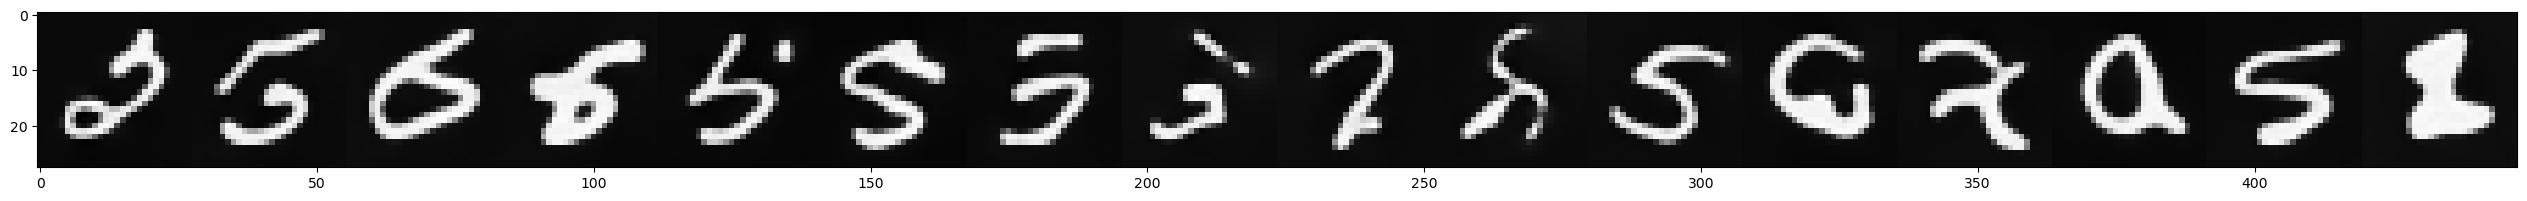

Epoch [100/100] | Train Loss: 0.0432 | Validation Loss: 0.0426 | Learning Rate: 0.0000250000


: 

In [ ]:
# Set the noise function to be used for training

# noise_function = diffusion.vignette
# noise_function = diffusion.pixellate

for epoch in range(EPOCHS):
    print("Epoch ",epoch)
    train_loss = 0
    for x, _ in tqdm(train_loader):
        optimizer.zero_grad()
        x = x.to(device)
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        x_t = noise_function(x, t)
        pred = model(x_t, t)
        loss = loss_fn(pred, x)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    val_loss = 0
    model.eval()
    with torch.no_grad(): 
        for x, _ in val_loader:

            #print(type(x))
            #print(x.shape)
            x = x.to(device)
            t = diffusion.sample_timesteps(x.shape[0]).to(device)
            x_t = noise_function(x, t)
            pred = model(x_t, t)
            batch_val_loss = loss_fn(pred, x)
            val_loss += batch_val_loss.item()

            del x, x_t, t, pred, batch_val_loss
        scheduler.step(val_loss/len(val_loader))
        # Sample only every n epochs for opt purposes
        if epoch%3 == 0:
            sampled_images = diffusion.sample(model, batch_size=16, initial_image=sampling_type, gmm=gmm, data_loader=val_loader)
            plot_images(sampled_images)
        
    # Save loss
    avg_train_loss = train_loss/len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    writer.add_scalar('Loss/val', avg_val_loss, epoch)
    writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f} | Learning Rate: {scheduler.get_last_lr()[0]:.10f}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

writer.close()


In [62]:
torch.save(model.state_dict(), './Models/DM/' + run_name + '.pth')
print("Model saved to ./Models/DM/" + run_name + '.pth')

Model saved to ./Models/DM/coldDiffusion_blur_s500_b32_gmm_5.0e-05_e100_L1_6000_scheduler_ReduceLROnPlateau.pth


In [ ]:
# LOAD MODEL
import joblib

LOAD_MODEL = True


if LOAD_MODEL:
    model.load_state_dict(torch.load('./Models/DM/coldDiffusion_blur_s40_b32_gmm_1.0e-04_e100_L1_6000_scheduler_ReduceLROnPlateau.pth'))
    gmm = joblib.load('gmm_model_steps100_sigma1.pkl')

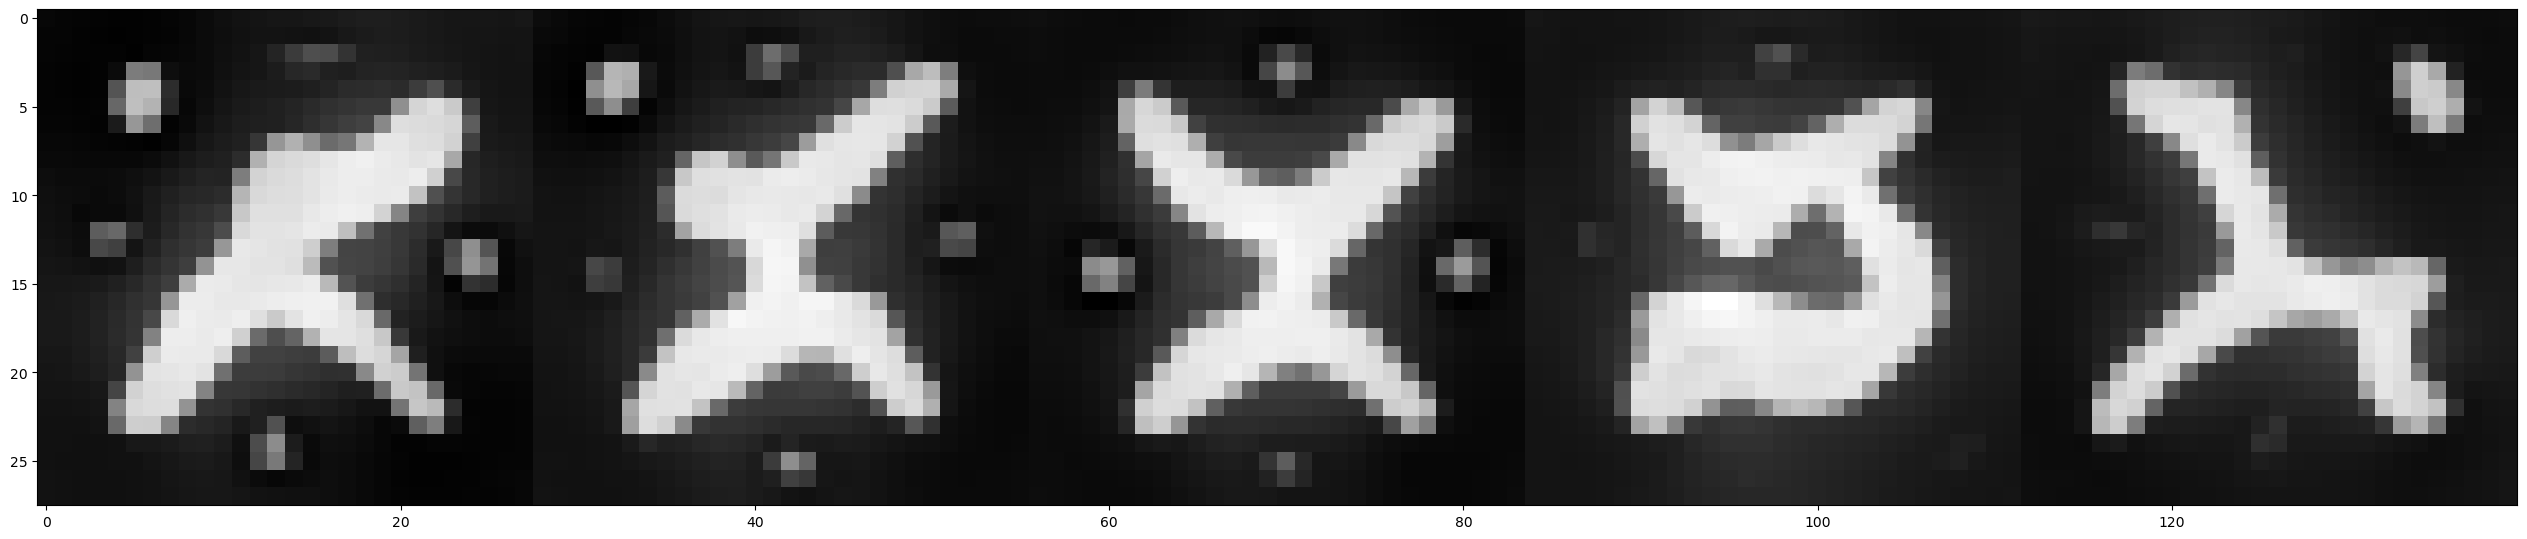

In [20]:
diff2 = coldDiff()
sampled_images = diff2.sample(model, batch_size=5, initial_image='gmm', gmm=gmm, data_loader=val_loader)
plot_images(sampled_images)

### FID

In [56]:
from pytorch_fid.inception import InceptionV3
from torchvision.utils import save_image
from torchvision.models import inception_v3
import torch.nn.functional as F
import numpy as np
from scipy.linalg import sqrtm


def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1-mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1+sigma2- 2*covmean)
    return fid

def get_activations(images, model, batch_size=32, dims=2048, device='cuda'):
    model.eval()
    pred_arr = np.empty((len(images), dims))
    with torch.no_grad():
        for i in tqdm(range(0, len(images), batch_size)):
            start = i
            end = i+batch_size
            batch = images[start:end].to(device)
            #print(batch.size())
            #raise
            pred = model(batch)[0]
            pred = F.adaptive_avg_pool2d(pred, output_size=(1,1))
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            pred_arr[start:end] = pred
    return pred_arr

#inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
#inception_model.fc = torch.nn.Identity()
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx]).to(device)

In [59]:
original_images = []
generated_images = []

model.eval()
FID_LIMIT = 500 # Limit the number of images to be generated for FID calculation
for i, (x, t) in tqdm(enumerate(train_loader)):
    if i > FID_LIMIT//x.shape[0]:
        break
    original_images.append(x)
    
    sampled = diffusion.sample(model, batch_size=x.shape[0], initial_image='gmm', gmm=gmm, data_loader=val_loader)
    generated_images.append(sampled)




16it [14:23, 53.99s/it]


In [60]:
        
del model

In [61]:
original_images = torch.cat(original_images, dim=0).to(device)
generated_images = torch.cat(generated_images, dim=0).to(device)

In [62]:
original_images.size(), generated_images.size()

(torch.Size([512, 1, 28, 28]), torch.Size([512, 1, 28, 28]))

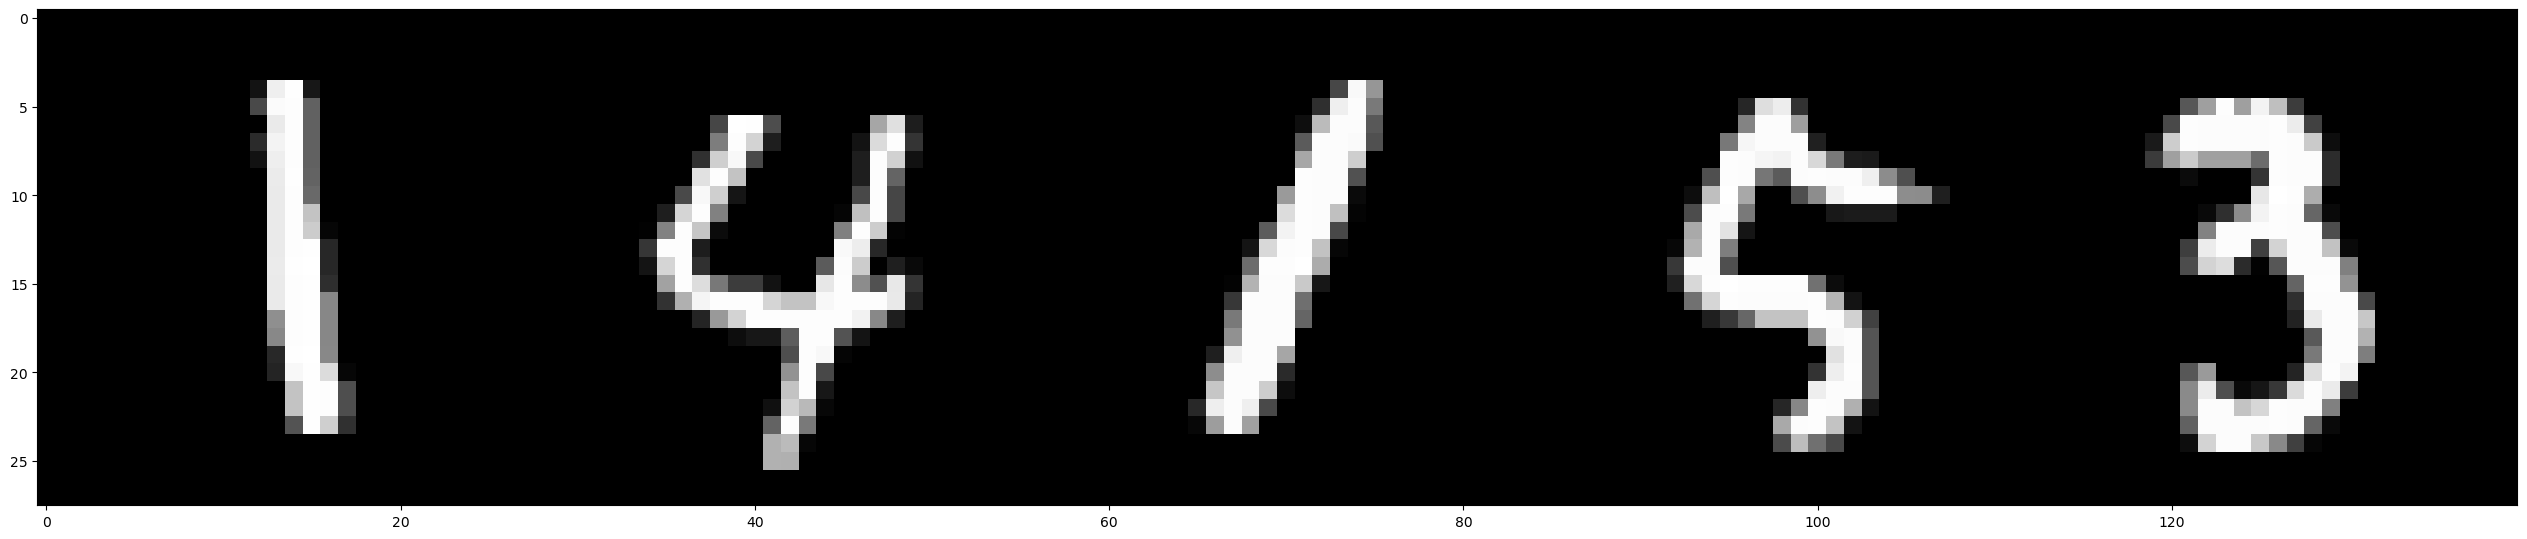

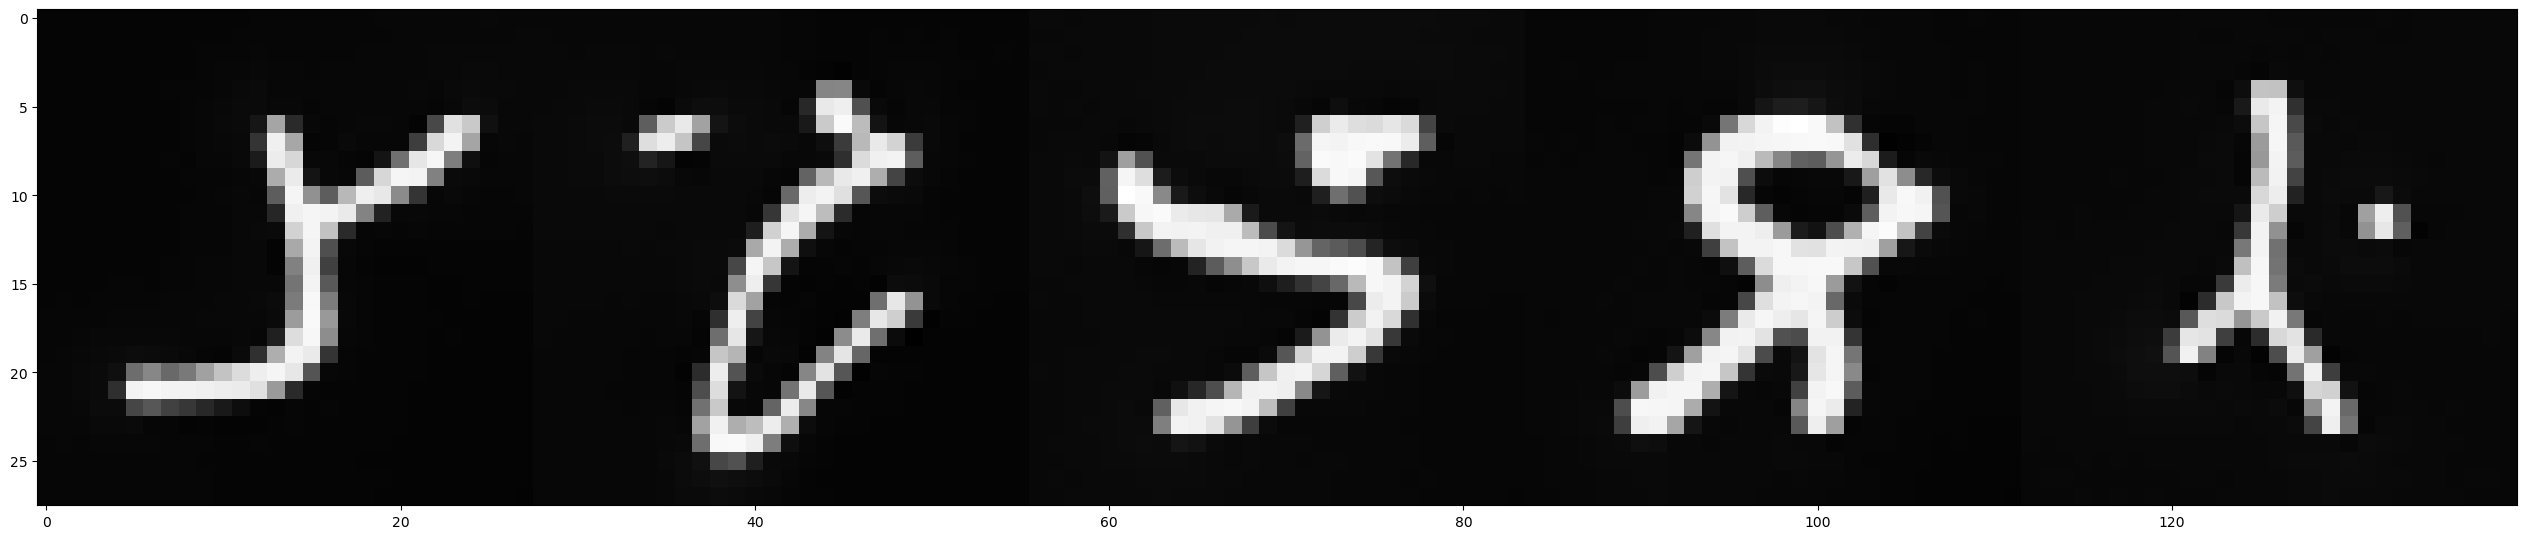

In [63]:
# Plot the images
plot_images(original_images[:5])
plot_images(generated_images[:5])

In [64]:
import torchvision.transforms as transforms
import torch

# Define transform
transform = transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel

original_transformed = []
generated_transformed = []

# Apply transform
for i in range(len(generated_images)):
    original_transformed.append(transform(original_images[i]))
    generated_transformed.append(transform(generated_images[i]))
    
# Stack back into batches
original_transformed = torch.stack(original_transformed)
generated_transformed = torch.stack(generated_transformed)


In [65]:
original_transformed.size(), generated_transformed.size()

(torch.Size([512, 3, 28, 28]), torch.Size([512, 3, 28, 28]))

In [66]:
import numpy as np

original_activations = get_activations(original_transformed, inception_model, device=device)
generated_activations = get_activations(generated_transformed, inception_model, device=device)

# Calculate mean and covariance of the activations
mu1 = np.mean(original_activations, axis=0)
sigma1 = np.cov(original_activations, rowvar=False)
mu2 = np.mean(generated_activations, axis=0)
sigma2 = np.cov(generated_activations, rowvar=False)

# Calculate FID score
fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
print('FID score:', fid_score)

100%|██████████| 16/16 [00:02<00:00,  7.37it/s]


FID score: 104.2251600106337


# FID using torchmetrics

In [ ]:
original_images[0][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [19]:
# Normalize the images to 0-255 from -1 to 1
original_images = (original_images + 1) / 2 * 255
generated_images = (generated_images + 1) / 2 * 255

# Convert to uint8
original_images = original_images.type(torch.uint8)
generated_images = generated_images.type(torch.uint8)



In [ ]:
# Break generated images into smaller batches for FID
batch_size = 32  # or even 16 if needed
for i in range(0, len(generated_images), batch_size):
    batch = generated_images[i:i+batch_size]

    fid.update(batch, real=False)

for i in range(0, len(original_images), batch_size):
    batch = original_images[i:i+batch_size]
    fid.update(batch, real=True)

NameError: name 'fake_images' is not defined

In [20]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance

with torch.no_grad():
    # Initialize FID
    fid = FrechetInceptionDistance(feature=2048)

    # Update real images
    fid.update(original_images, real=True)

    # Update generated images
    fid.update(generated_images, real=False)

    # Compute FID
    fid_score = fid.compute()
    print("FID:", fid_score.item())

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.12 GiB is allocated by PyTorch, and 33.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [66]:
import importlib
importlib.reload(torchmetrics.image.fid)

NameError: name 'torchmetrics' is not defined

### Use GMM to sample images

In [ ]:
from sklearn.mixture import GaussianMixture

test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

diffusion = coldDiff()

fully_degraded_images = []

for x, _ in test_loader:
    x = x.to(device)
    t = diffusion.sample_timesteps(x.shape[0]).to(device)
    x_t = diffusion.blur(x, t)
    flattened_images = x_t.view(x_t.size(0), -1).detach().cpu().numpy()
    fully_degraded_images.extend(flattened_images)

    
fully_degraded_images = np.array(fully_degraded_images)

gmm = GaussianMixture(n_components=3)
gmm.fit(fully_degraded_images)

In [ ]:
n_samples = 100
sampled_images = gmm.sample(n_samples)[0]
initial_images = torch.tensor(sampled_images).float().to(device)
initial_images = initial_images.view(n_samples, 1, 28, 28)
plot_images(initial_images)

In [ ]:
initial_images.shape

In [ ]:
sampled_intensities = gmm.sample(n_samples)

In [ ]:
len(sampled_intensities)

In [ ]:
import joblib

In [ ]:
joblib.dump(gmm, 'Models/DM/gmm_blur_coldDiff.joblib')